<div style="background-color: red; color: darkblue; font-size: 34px; padding: 15px;">Authorship: Nikolin Prenga</div>

<div style="background-color: red; color: darkblue; font-size: 34px; padding: 15px;">Created on 17 Jun, 2024</div>

<div style="background-color: lime; color: darkblue; font-size: 34px; padding: 15px;">  In this Jupyter Notebook, we will train, evaluate, and test machine learning models, particularly U-Net and Fully Convolutional Network (FCN),
for semantic segmentation using the 2018 Data Science Bowl dataset.
 </div>

In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import nibabel as nib
import os
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
import tensorflow
import zipfile
import cv2
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm
import os
import shutil
import zipfile
from tensorflow.keras.callbacks  import CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc

- <span style="font-size:30px; color:blue;">  Import the implemented metrics from Nikolin's Metrics module </span>


In [3]:
from Metrics import Dice_Coef, multi_class_precision, multi_class_recall, multi_class_specificity, custom_mean_ioutow, f1_score

In [4]:

epoch_number_unet1 = 41
num_epochs_fcn_1 =35
epoch_numer_all_unet=45

num_epochs_fcn_all=37

- <span style="font-size:30px; color:blue;">  Import data loader from Nikolin's module Data_GeneratorSemantic_Segmentation </span>


In [5]:
from Data_generatorSementic_Segmentation import X_train, y_train, X_val, y_val, X_test, y_test

from Data_generatorSementic_Segmentation import All_imagage_train, All_masks_train, Unseen_data_images




Number of images and masks match.

Shape of Data_X: (616, 128, 128, 3)
Shape of X_test: (54, 128, 128, 3)
Shape of Data_y: (616, 128, 128, 1)
Shape of y_test: (54, 128, 128, 1)

Shape of X_train: (535, 128, 128, 3)
Shape of X_val: (81, 128, 128, 3)
Shape of y_train: (535, 128, 128, 1)
Shape of y_val: (81, 128, 128, 1)


- <span style="font-size:30px; color:red;">  Plot some images and masks from training dataset </span>


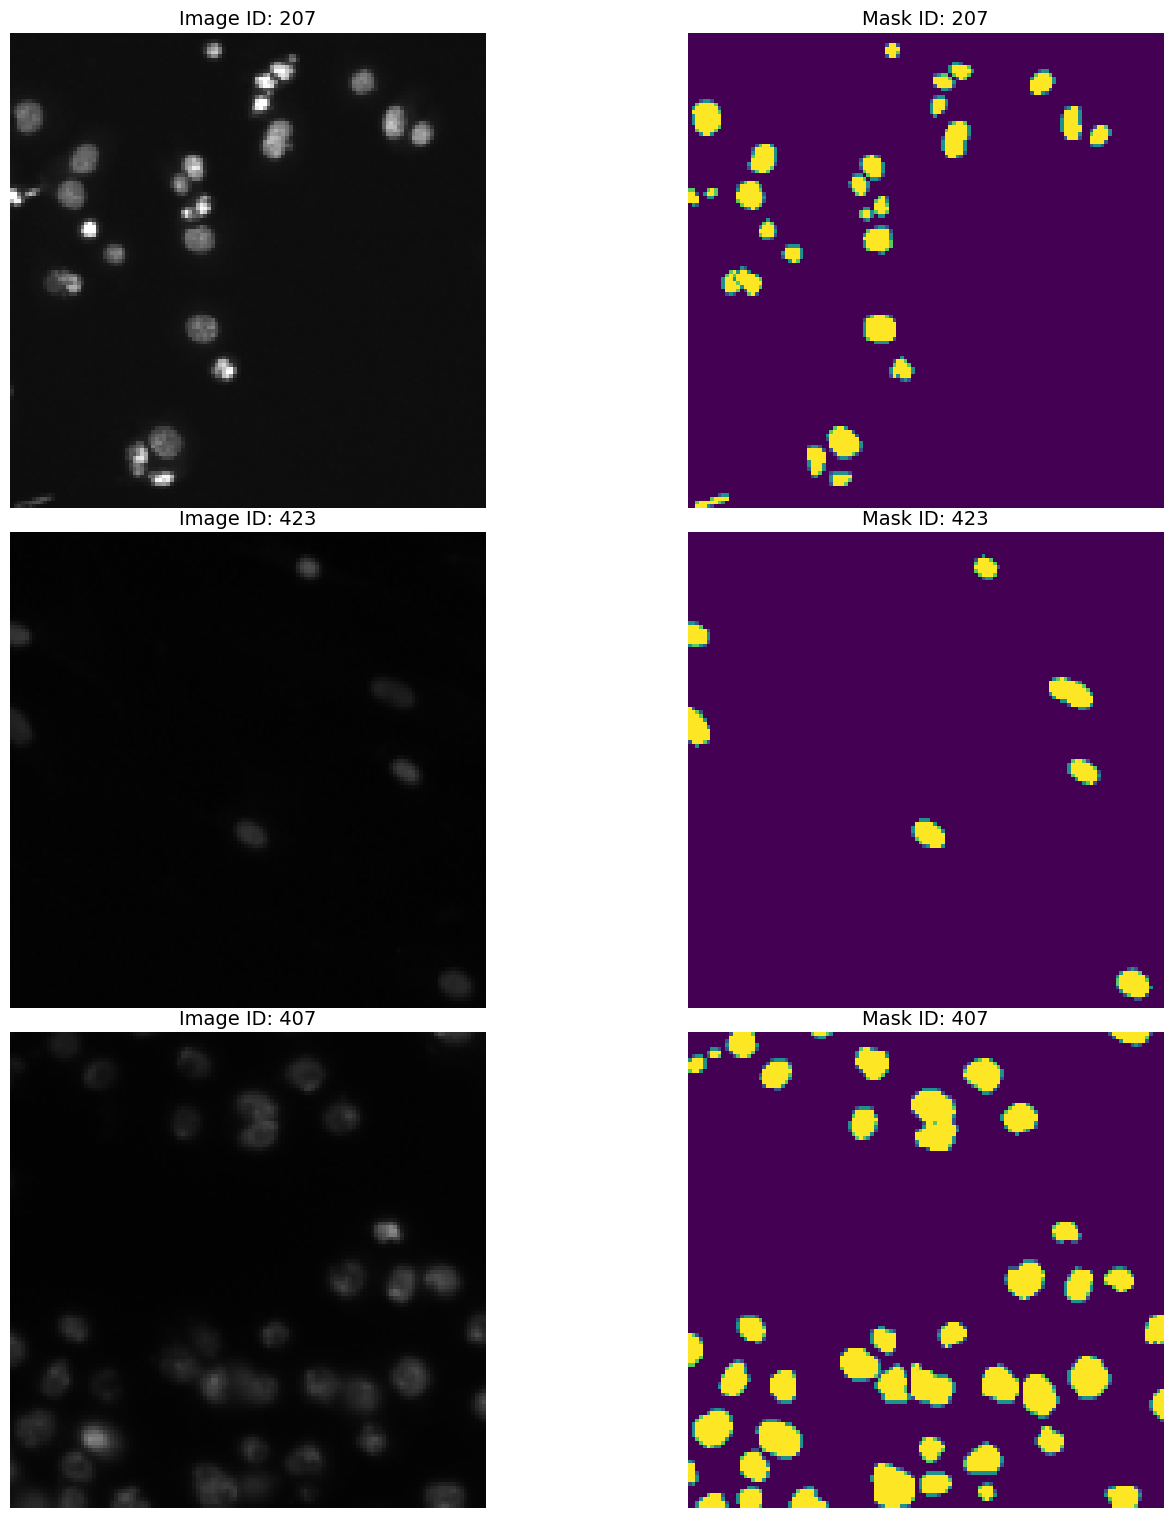

In [7]:
index1= int(np.random.uniform(0, 480))
index2 =int(np.random.uniform(0, 480))
index3 = int(np.random.uniform(0, 480))



plt.figure(figsize=(15, 15))
plt.subplot(3,2, 1)
plt.imshow(All_imagage_train[index1])
plt.axis('off')
plt.title(f'Image ID: {index1}', fontsize=14)

plt.subplot(3,2, 2)
plt.imshow(All_masks_train[index1])
plt.axis('off')
plt.title(f'Mask ID: {index1}', fontsize=14)

plt.subplot(3,2, 3)
plt.imshow(All_imagage_train[index2])
plt.axis('off')
plt.title(f'Image ID: {index2}', fontsize=14)


plt.subplot(3,2, 4)
plt.imshow(All_masks_train[index2])
plt.axis('off')
plt.title(f'Mask ID: {index2}', fontsize=14)

plt.subplot(3,2, 5)
plt.imshow(All_imagage_train[index3])
plt.axis('off')
plt.title(f'Image ID: {index3}', fontsize=14)

plt.subplot(3,2, 6)
plt.imshow(All_masks_train[index3])
plt.axis('off')
plt.title(f'Mask ID: {index3}', fontsize=14)

plt.subplots_adjust(wspace=0.2, hspace=0.001)  # Adjust wspace and hspace as needed
plt.tight_layout(pad=0.05)
plt.show()

- <span style="font-size:30px; color:blue;">  Plot some images from testing dataset </span>

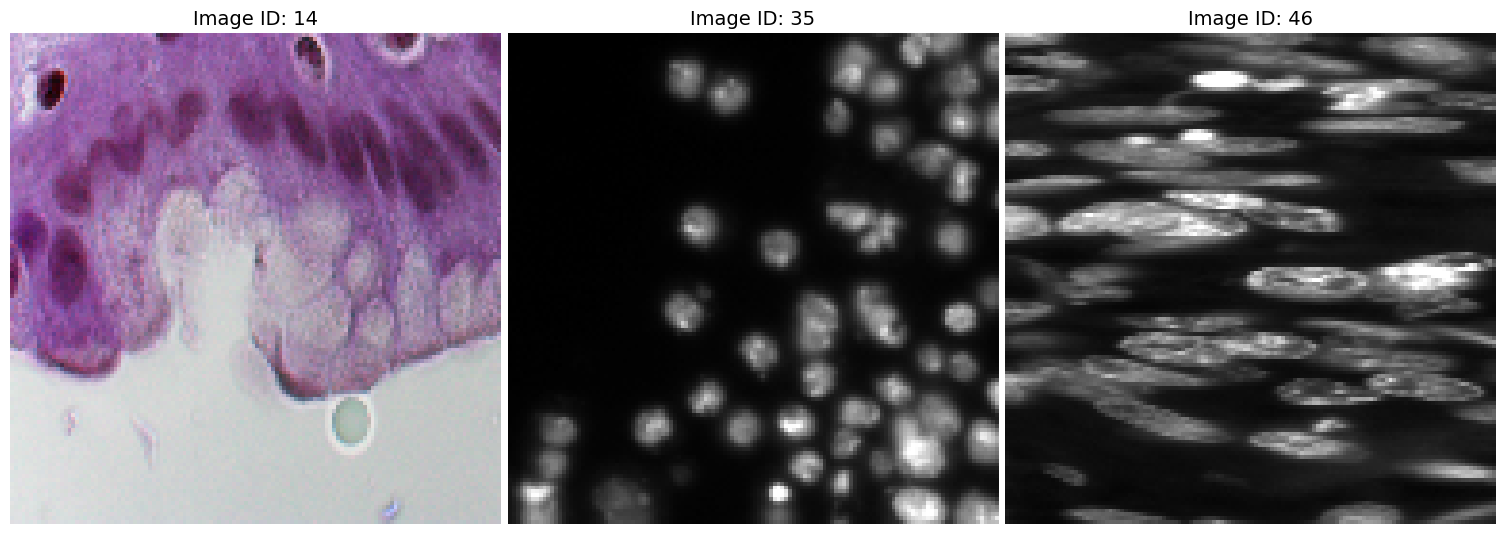

In [10]:

index_1= int(np.random.uniform(0, 64))
index_2 =int(np.random.uniform(0, 64))
index_3 = int(np.random.uniform(0, 64))
plt.figure(figsize=(15, 10))
plt.subplot(1,3, 1)
plt.imshow(Unseen_data_images[index_1])
plt.axis('off')
plt.title(f'Image ID: {index_1}', fontsize=14)

plt.subplot(1,3, 2)
plt.imshow(Unseen_data_images[index_2])
plt.axis('off')
plt.title(f'Image ID: {index_2}', fontsize=14)

plt.subplot(1,3, 3)
plt.imshow(Unseen_data_images[index_3])
plt.axis('off')
plt.title(f'Image ID: {index_3}', fontsize=14)

#plt.subplots_adjust(wspace=0.2, hspace=0.01)  # Adjust wspace and hspace as needed
plt.tight_layout(pad=0.5)
plt.show()

- <span style="font-size:30px; color:blue;"> This is a binary pixel classification problem, therefore we prefer to have the object represented with 1 and the background with 0 pixels.</span>

In [22]:
Unseen_data_images.shape

(65, 128, 128, 3)

In [5]:
y_train= (y_train>=0.5).astype(np.int8)
y_val= (y_val>=0.5).astype(np.int8)
y_test= (y_test>=0.5).astype(np.int8)

- <span style="font-size:30px; color:green;">Here we want to glance at whether the pixels in the mask are balanced or not. This plays an important role when training the algorithms.</span>

[0 1]
Percentage of 0s (background): 84.72%
Percentage of 1s (objects): 15.28%


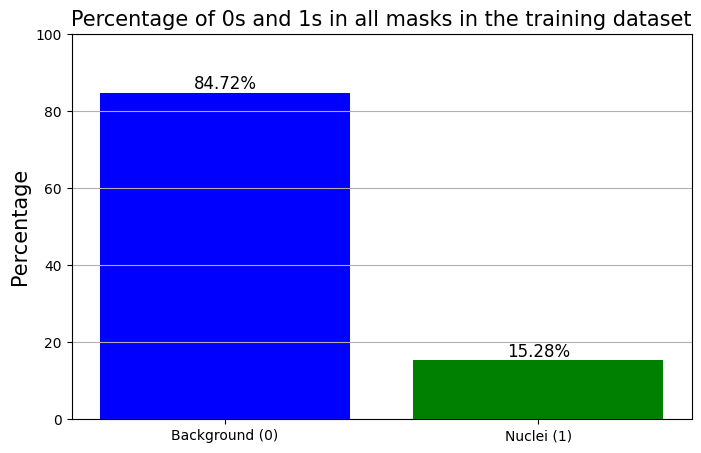

In [6]:
copy_masks = All_masks_train.copy()

copy_masks = (copy_masks>0).astype(np.int8)
copy_masks.shape

flattened_masks = copy_masks.flatten()



# Flatten the masks to count the 1s and 0s

flattened_masks = copy_masks.flatten()

# Count the number of 0s and 1s
unique, counts = np.unique(flattened_masks, return_counts=True)
mask_counts = dict(zip(unique, counts))
print(unique)

# Calculate the percentages
total_pixels = flattened_masks.size
percentage_zeros = (mask_counts[0] / total_pixels) * 100
percentage_ones = (mask_counts[1] / total_pixels) * 100

# Print the percentages
print(f"Percentage of 0s (background): {percentage_zeros:.2f}%")
print(f"Percentage of 1s (objects): {percentage_ones:.2f}%")

# Create a bar plot
labels = ['Background (0)', 'Nuclei (1)']
percentages = [percentage_zeros, percentage_ones]

plt.figure(figsize=(8, 5))
plt.bar(labels, percentages, color=['blue', 'green'])
plt.ylabel('Percentage', fontsize=15)
plt.title('Percentage of 0s and 1s in all masks in the training dataset', fontsize=15)
plt.ylim(0, 100)
plt.grid(axis='y')

# Add text annotations
for i, v in enumerate(percentages):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=12)

plt.show()

In [7]:

################################################################################################################################
# This function takes images, their masks, an index where to start in the data, the number of images chosen by the user, and a trained model.
# It predicts the mask for each image using the model. When the mask is predicted, we merge them into a single image separated by a line.
# On the left, we have the real image, in the middle we have the true mask, and on the right, we have the predicted mask from the image.
################################################################################################################################


def predict_mask_and_mergeimage(Real_images, Its_real_mask, start_index, num_predicions, model):

    for index in range(start_index, start_index +num_predicions ):
        mask = Its_real_mask[index]
        image = Real_images[index]
    
    
        plt.figure(figsize=(12,12))
        image_input = np.expand_dims(image, axis=0)  # Add batch dimension
        image=image*255
        y_pred = model.predict(image_input, verbose=0)[0]
        y_pred = (y_pred >= 0.5).astype(np.uint8)  # Apply threshold

        # # Expand dimensions to have 3 channels for visualization
        # if mask.shape[-1] == 1:
        #     mask = np.squeeze(mask, axis=-1)
        # mask = np.stack([mask] * 3, axis=-1) * 255  # Convert mask to 3 channels

        # if y_pred.shape[-1] == 1:
        #     y_pred = np.squeeze(y_pred, axis=-1)
        # y_pred = np.stack([y_pred] * 3, axis=-1) * 255  # Convert prediction to 3 channels

        # Apply color maps to the masks
        mask_colored = np.zeros_like(image)
        y_pred_colored = np.zeros_like(image)

        for i in range(3):  # Apply the mask to all color channels
            mask_colored[..., i] = np.squeeze(mask) * 255
            y_pred_colored[..., i] = np.squeeze(y_pred) * 255

        # Create a separator line
        line = np.ones((image.shape[0], 5, 3)) * 200

        # Concatenate image, real mask, and predicted mask
        #merged_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
        merged_images = np.concatenate([image, line, mask_colored, line, y_pred_colored], axis=1)

        # Plot the concatenated image
        plt.figure(figsize=(12, 4))
        plt.title('True Image (Left)              |    True Mask (Middle)       |   Predicted Mask (Right)', fontsize=17)
        plt.imshow(merged_images.astype(np.uint8), cmap="YlGnBu")
        plt.xlabel('Merged Images')
        plt.axis('off')
        plt.show()


In [29]:
################################################################################################################################
# This function takes images, their masks, a starting index, the number of images to predict, and a trained model.
# It predicts the mask for each image using the model and displays the original image, the true mask, and the predicted mask side by side.
# The function plots these images in a grid, with each row corresponding to an image and its respective masks.
################################################################################################################################

def predict_mask_nomerge(images, maskes, index_start, number_images, model):

    plt.figure(figsize=(27,14))

    for iter in range(index_start, index_start+number_images):
        image = images[iter]
        mask = maskes[iter]
        input_image = np.expand_dims(image, axis=0)
        pred_image = model.predict(input_image, verbose=0)[0]

        pred_image = (pred_image>=0.5).astype(np.int8)

        pred_image = np.squeeze(pred_image, axis=-1)

        index= (iter - index_start) * 3 

        plt.subplot(number_images, 3, index+1)
        plt.imshow(image, cmap='viridis')
        plt.title(f'Image ID: {iter}', fontsize=16)
        plt.axis('off')

        plt.subplot(number_images, 3, index+2)
        plt.imshow(mask, cmap='viridis')
        plt.title(f'Ground Truth Mask ID: {iter}', fontsize=16)
        plt.axis('off')

        plt.subplot(number_images, 3, index+3)
        plt.imshow(pred_image, cmap='viridis')
        plt.title(f'Predicted Mask ID: {iter}', fontsize=16)
        plt.axis('off')

        plt.subplots_adjust(left=0.1, right=0.4, top=1, bottom=0.33, wspace=0.01, hspace=0.1)
    plt.show()

<div style="background-color: red; color: darkblue; font-size: 34px; padding: 15px;">Stage One - Initial Training and Evaluation: </div>

# Key Points

- <span style="font-size:30px; color:blue;">The 2018 Data Science Bowl competition provided a training set with images and annotated masks as labels, and a testing dataset without labels or annotated masks.</span>


- <span style="font-size:25px; color:deeppink;">Training and Evaluating U-Net 2D on Segmented Nuclei Images (The 2018 Data Science Bowl competition) </span>

- <span style="font-size:25px; color:blue;"> To be able to compare and evaluate the model, we divided the training dataset provided by the Data Science Bowl 2018 competition into training, validation, and testing datasets as holdout data.  </span>

- <span style="font-size:25px; color:green;"> Thus, the training dataset from the Data Science Bowl 2018 competition is divided into training, validation, and testing datasets.  </span>

- <span style="font-size:25px; color:olive;"> In the next phase, the training dataset will be utilized solely to train and validate the model, while the provided testing dataset will be used for prediction.  </span>

- <span style="font-size:30px; color:navy;">The training dataset from the Data Science Bowl is split 92% for model training and 8% for testing the model, allowing comparison of the predictions with the ground truth masks.</span>

- <span style="font-size:30px; color:darkblue;">Furthermore, the 92% of the dataset is split further into 87% for training the model and 13% for validating the model during the training phase.</span>
- <span style="font-size:30px; color:darkgreen;">Here we deploy the U-Net 2D model.</span>

In [9]:
from Models2D import My_Unet_2D

In [10]:
input_layer = (128 ,128, 3)
optimaz= tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

model_unet2d_internal = My_Unet_2D(input_size=input_layer, num_filter=40, Pool_size =2 ,  pool_stride=2, drop_rate=0.3, num_classes=2)

model_unet2d_internal.compile(loss="binary_crossentropy",
              optimizer=optimaz,
              metrics = ['accuracy',custom_mean_ioutow,
                          Dice_Coef, multi_class_precision, multi_class_recall, multi_class_specificity, f1_score] )





# Create directory for storing files
if not os.path.exists("Files"):
    os.makedirs("Files")

# Hyperparameters and file paths
model_path = os.path.join("Files", "MyModel.h5")
csv_path = os.path.join("Files", "training.log")

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001, verbose=1),
    
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True, save_weights_only=True),

    CSVLogger(csv_path, separator=',', append=False),
    
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]



history_Notall =model_unet2d_internal.fit(X_train, y_train,
          epochs=epoch_number_unet1,
          callbacks=callbacks,
          validation_data=(X_val, y_val))

Block_6_upsample -- (None, 16, 16, 320)
Block4_Conv8 -- (None, 16, 16, 320)
Sigmoid used
Epoch 1/41
17/17 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.8083 - custom_mean_ioutow: 0.0198 - Dice_Coef: 0.2111 - multi_class_precision: 0.0592 - multi_class_recall: 0.0646 - multi_class_specificity: 0.9436 - f1_score: 0.0340
Epoch 1: val_loss improved from inf to 0.55730, saving model to Files/MyModel.h5
17/17 [==============================] - 53s 3s/step - loss: 0.6377 - accuracy: 0.8083 - custom_mean_ioutow: 0.0198 - Dice_Coef: 0.2111 - multi_class_precision: 0.0592 - multi_class_recall: 0.0646 - multi_class_specificity: 0.9436 - f1_score: 0.0340 - val_loss: 0.5573 - val_accuracy: 0.8628 - val_custom_mean_ioutow: 1.8124e-15 - val_Dice_Coef: 0.1833 - val_multi_class_precision: 0.0000e+00 - val_multi_class_recall: 0.0000e+00 - val_multi_class_specificity: 1.0000 - val_f1_score: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/41
17/17 [==============================] - ETA: 0s -

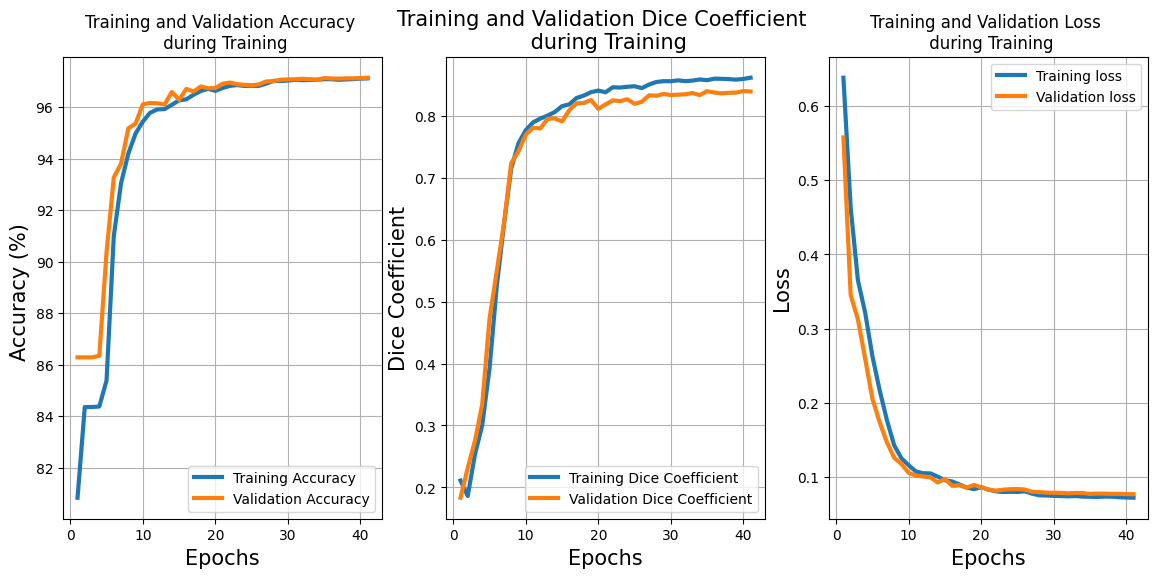

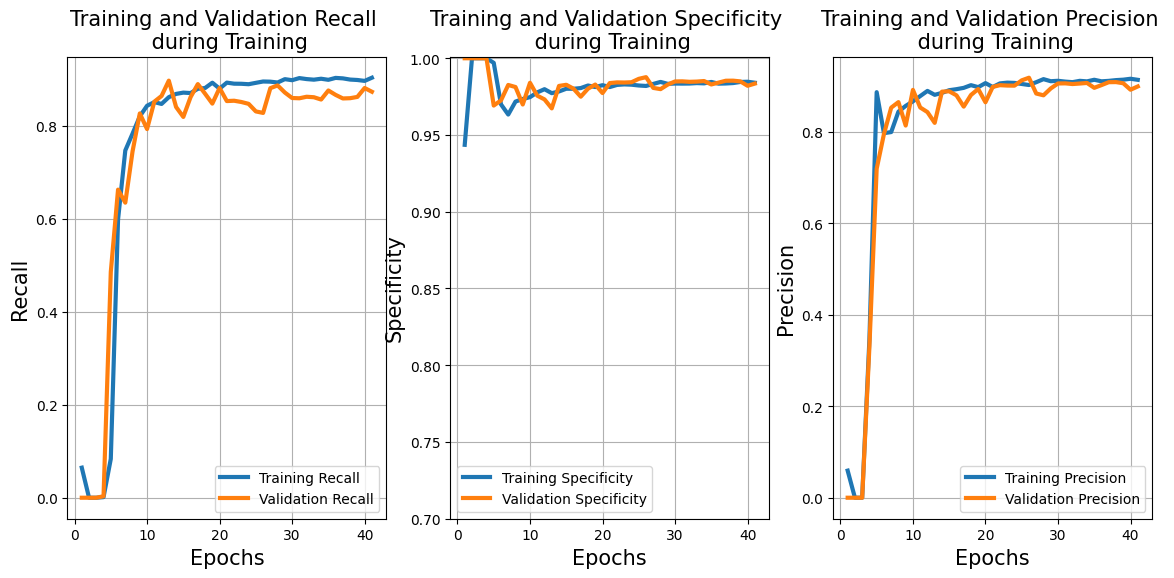

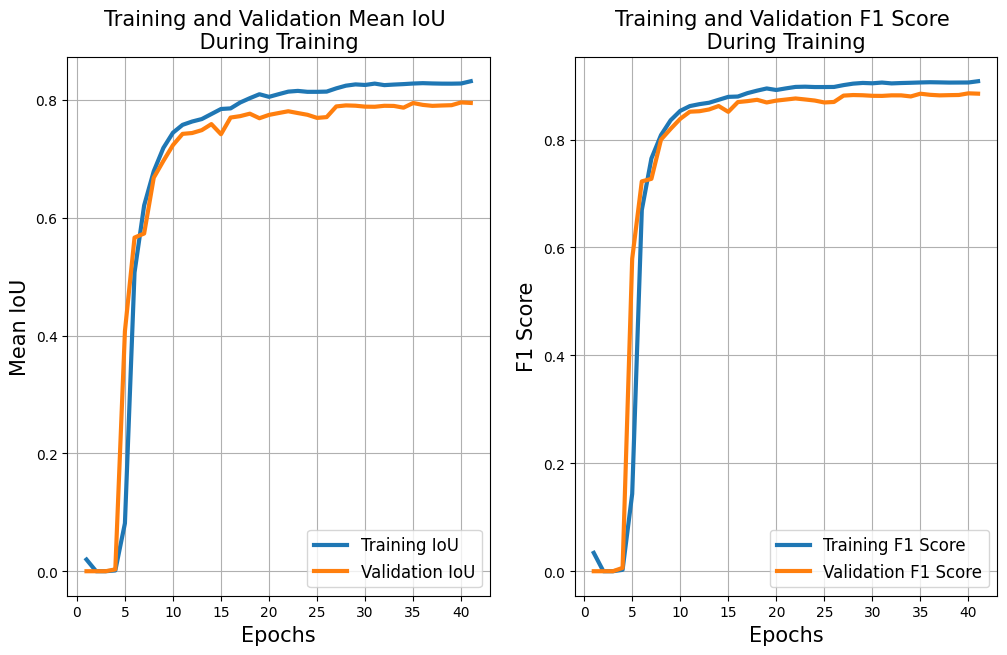

In [26]:

x_epochs= list(range(1, epoch_number_unet1+1))


#################################################################################
loss_train = history_Notall.history['loss']
loss_val = history_Notall.history['val_loss']

Train_acc=   [  item*100 for item in history_Notall.history['accuracy'] ]

Val_acc =[item*100 for item in history_Notall.history['val_accuracy'] ]


#train_mean_io = history_Notall.history['mean_io_u_2']
#val_mean_io = history_Notall.history['val_mean_io_u_2']

precision_train = history_Notall.history['multi_class_precision']
precision_val = history_Notall.history['val_multi_class_precision']

dice_train = history_Notall.history['Dice_Coef']
dice_val = history_Notall.history['val_Dice_Coef']

train_recall = history_Notall.history['multi_class_recall']
val_recall = history_Notall.history['val_multi_class_recall']

specificity_train = history_Notall.history['multi_class_specificity']
specificity_val = history_Notall.history['val_multi_class_specificity']

IoU_train =history_Notall.history['custom_mean_ioutow']
IoU_val =history_Notall.history['val_custom_mean_ioutow']

f1_train =history_Notall.history['f1_score']
f1_val =history_Notall.history['val_f1_score']
# #################################################################################





plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(x_epochs, Train_acc, lw=3, label='Training Accuracy')
plt.plot(x_epochs, Val_acc, lw=3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy \n during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy (%) ', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(x_epochs, dice_train, lw=3, label='Training Dice Coefficient')
plt.plot(x_epochs, dice_val, lw=3, label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Dice Coefficient', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(x_epochs, loss_train, lw=3, label='Training loss')
plt.plot(x_epochs, loss_val, lw=3, label='Validation loss')
plt.title('Training and Validation Loss \n during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(x_epochs, train_recall, lw=3, label='Training Recall')
plt.plot(x_epochs, val_recall, lw=3, label='Validation Recall')
plt.title('Training and Validation Recall \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.legend()
plt.grid()


plt.subplot(1, 3, 2)
plt.plot(x_epochs, specificity_train, lw=3, label='Training Specificity')
plt.plot(x_epochs, specificity_val, lw=3, label='Validation Specificity')
plt.title('Training and Validation Specificity \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Specificity', fontsize=15)
plt.ylim(0.7,1.001)
plt.legend()
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(x_epochs, precision_train, lw=3, label='Training Precision')
plt.plot(x_epochs, precision_val, lw=3, label='Validation Precision')
plt.title('Training and Validation Precision \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, IoU_train,lw=3, label='Training IoU')
plt.plot(x_epochs, IoU_val, lw=3, label='Validation IoU')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean IoU', fontsize=15)
plt.title('Training and Validation Mean IoU \n During Training ', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(x_epochs, f1_train,lw=3, label='Training F1 Score')
plt.plot(x_epochs, f1_val, lw=3, label='Validation F1 Score')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('Training and Validation F1 Score \n During Training ', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()

<Figure size 1200x1200 with 0 Axes>

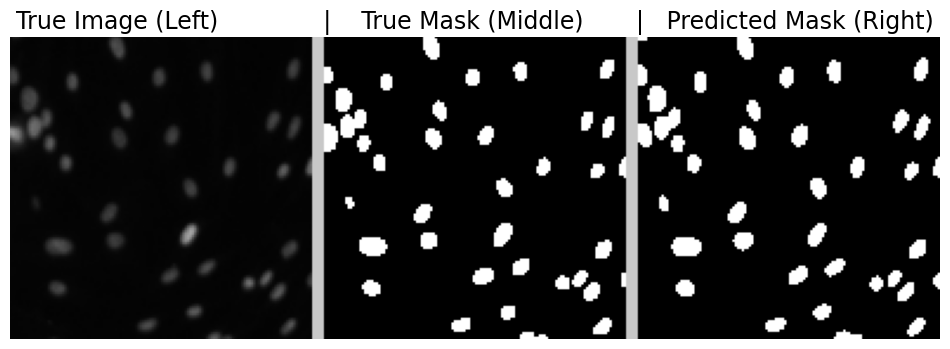

<Figure size 1200x1200 with 0 Axes>

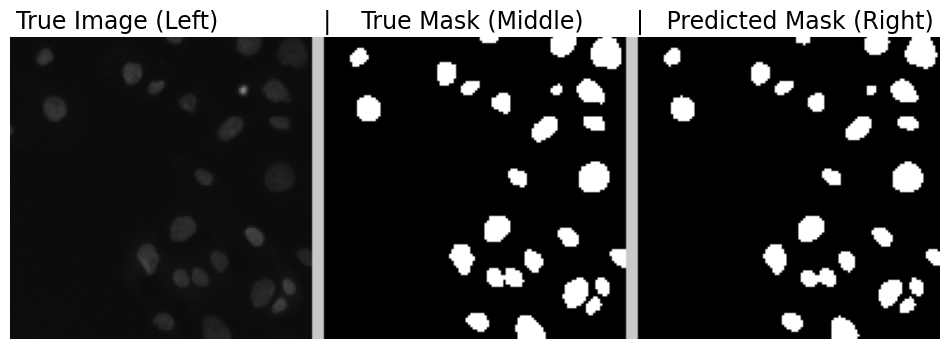

<Figure size 1200x1200 with 0 Axes>

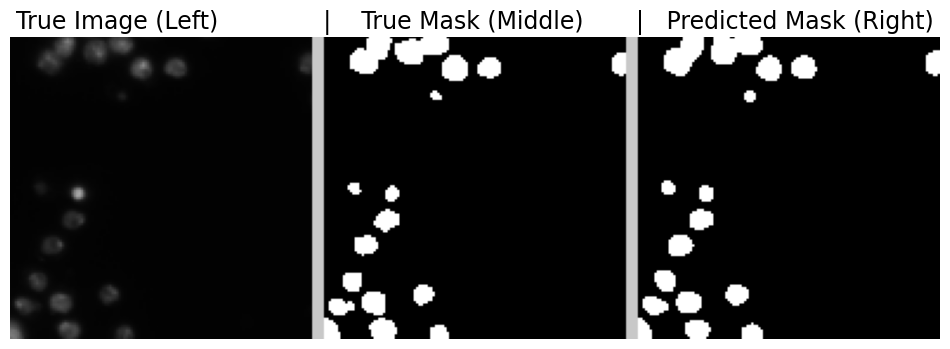

In [40]:
predict_mask_and_mergeimage(X_test, y_test, 7, 3, model_unet2d_internal)


<Figure size 1200x1200 with 0 Axes>

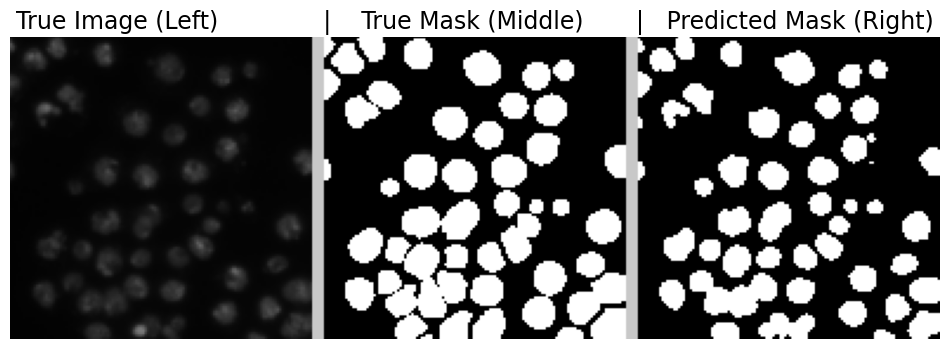

<Figure size 1200x1200 with 0 Axes>

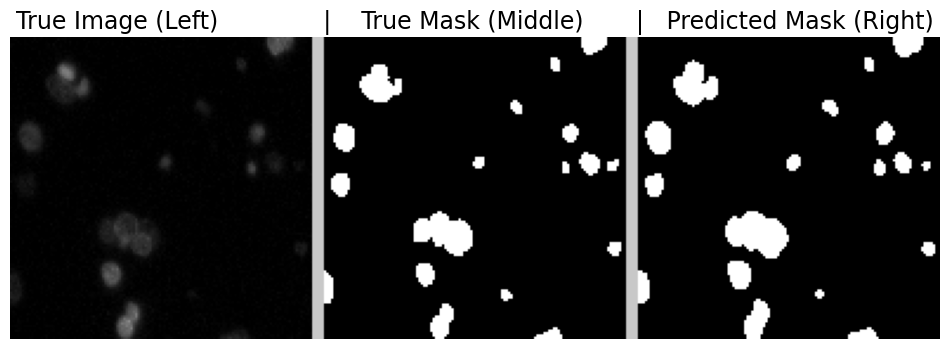

<Figure size 1200x1200 with 0 Axes>

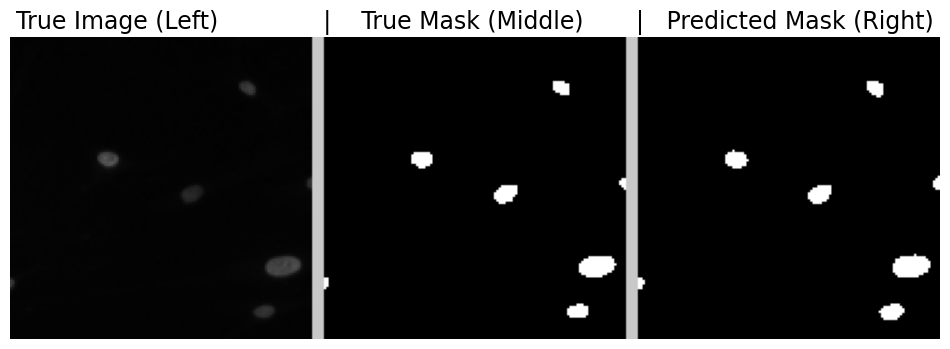

In [39]:
predict_mask_and_mergeimage(X_test, y_test, 36, 3, model_unet2d_internal)


In [42]:
y_test.shape

(81, 128, 128, 1)

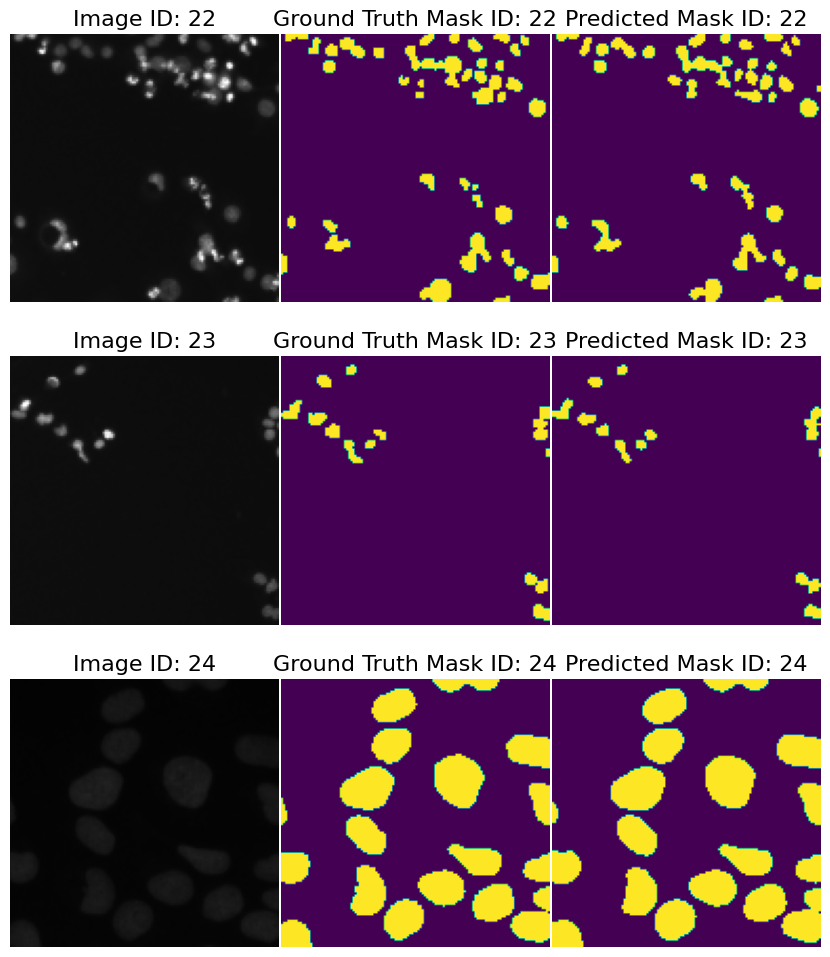

In [41]:
predict_mask_nomerge(X_test, y_test, 22, 3, model_unet2d_internal)

- <span style="font-size:30px; color:darkgreen;">Testing the Metrics for U-Net on the Held-out Dataset </span>

3/3 [==============================] - 3s 773ms/step
              precision    recall  f1-score   support

     Pixel 0       0.98      0.99      0.98   1145041
     Pixel 1       0.91      0.88      0.89    182063

    accuracy                           0.97   1327104
   macro avg       0.94      0.93      0.94   1327104
weighted avg       0.97      0.97      0.97   1327104



IoU Mean: 0.8095
Dice Coefficient: 0.8947


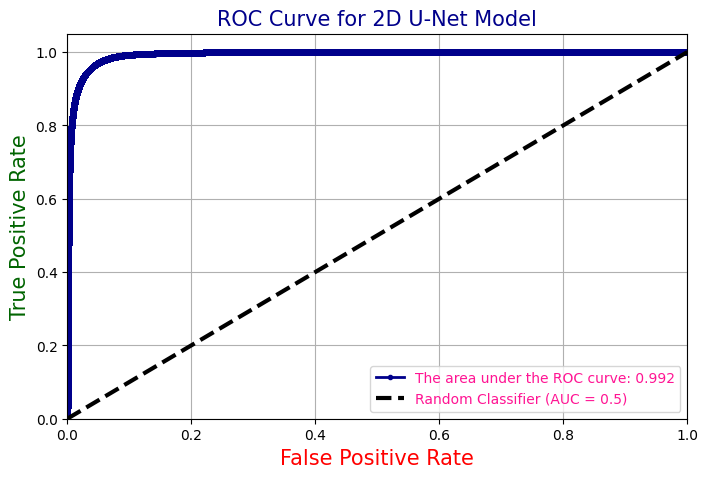

In [43]:
from sklearn import metrics
unseen_masks= y_test.copy()
# Generating predictions
y_pred_proba_Unet = model_unet2d_internal.predict(X_test)
y_pred_unet = (y_pred_proba_Unet >= 0.5).astype(np.uint8)  # Apply threshold to get binary masks

# Flattening the masks
y_pred_proba_Unet = y_pred_proba_Unet.flatten()
y_test_flat_unet = unseen_masks.flatten()
y_pred_unet = y_pred_unet.flatten()



target_names = ['Pixel 0', 'Pixel 1']
print(classification_report(y_test_flat_unet, y_pred_unet, target_names=target_names))

print('\n')

intersection_unet = np.sum(y_test_flat_unet * y_pred_unet)
dice_coefficient_unet = (2. * intersection_unet) / (np.sum(y_test_flat_unet) + np.sum(y_pred_unet))

# Computing IoU (Intersection over Union)
union_unet = np.sum(y_test_flat_unet) + np.sum(y_pred_unet) - intersection_unet
iou_mean_unet = intersection_unet / union_unet
print(f"IoU Mean: {iou_mean_unet:.4f}")
print(f"Dice Coefficient: {dice_coefficient_unet:.4f}")





fpr_unet, tpr_unet, _ = roc_curve(y_test_flat_unet, y_pred_proba_Unet) 
roc_auc_unet = np.round(auc(fpr_unet, tpr_unet), 3)
# Plot the ROC curve
plt.figure(figsize=(8,5))  
plt.plot(fpr_unet, tpr_unet, '.-', lw=2, color='darkblue',  label=f'The area under the ROC curve: {roc_auc_unet}')
plt.plot([0, 1], [0, 1], 'k--', lw=3, color='black', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15, color='red')
plt.ylabel('True Positive Rate', fontsize=15, color='darkgreen')
plt.title('ROC Curve for 2D U-Net Model', fontsize=15, color='darkblue')


legend = plt.legend()
for text in legend.get_texts():
    text.set_color('deeppink')

# ax = plt.gca()
# ax.xaxis.label.set_color('blue')
# ax.yaxis.label.set_color('blue')
plt.grid(True)
plt.show()


- <span style="font-size:30px; color:darkgreen;">Here we deploy the Fully Convolutional Networks customized VGG-like architecture with doubling filters  </span>

In [44]:
 #Importing the custom VGG-like architecture with doubling filters model from the separate script for testing purposes



from Models2D import FullyConvolutional_NeuralNetWork

optimaz_fcn= tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
my_call_backs_fcn = EarlyStopping(monitor='val_loss', patience=10)
FCN_model_Notall = FullyConvolutional_NeuralNetWork(input_shape=(128, 128, 3), filter_choice=35, drop_rate=0.3, num_classes=1)

# Compile the model
FCN_model_Notall.compile(optimizer=optimaz_fcn, loss='binary_crossentropy', metrics=['accuracy',custom_mean_ioutow,
                          Dice_Coef, multi_class_precision, multi_class_recall, multi_class_specificity,f1_score])

# Model summary
#model_test.summary()



History_fcn_Notall =FCN_model_Notall.fit(X_train, y_train, epochs=num_epochs_fcn_1,
                      callbacks=my_call_backs_fcn, validation_data=(X_val, y_val), batch_size=32)


Epoch 1/35
17/17 [==============================] - 77s 4s/step - loss: 0.6881 - accuracy: 0.5685 - custom_mean_ioutow: 0.1286 - Dice_Coef: 0.2370 - multi_class_precision: 0.1587 - multi_class_recall: 0.4072 - multi_class_specificity: 0.5985 - f1_score: 0.2277 - val_loss: 0.6732 - val_accuracy: 0.5807 - val_custom_mean_ioutow: 0.1136 - val_Dice_Coef: 0.2128 - val_multi_class_precision: 0.1388 - val_multi_class_recall: 0.3906 - val_multi_class_specificity: 0.6110 - val_f1_score: 0.2036
Epoch 2/35
17/17 [==============================] - 69s 4s/step - loss: 0.6477 - accuracy: 0.6094 - custom_mean_ioutow: 0.1197 - Dice_Coef: 0.2315 - multi_class_precision: 0.1566 - multi_class_recall: 0.3402 - multi_class_specificity: 0.6598 - f1_score: 0.2135 - val_loss: 0.6046 - val_accuracy: 0.6668 - val_custom_mean_ioutow: 0.0988 - val_Dice_Coef: 0.2064 - val_multi_class_precision: 0.1370 - val_multi_class_recall: 0.2665 - val_multi_class_specificity: 0.7304 - val_f1_score: 0.1797
Epoch 3/35
17/17 [==

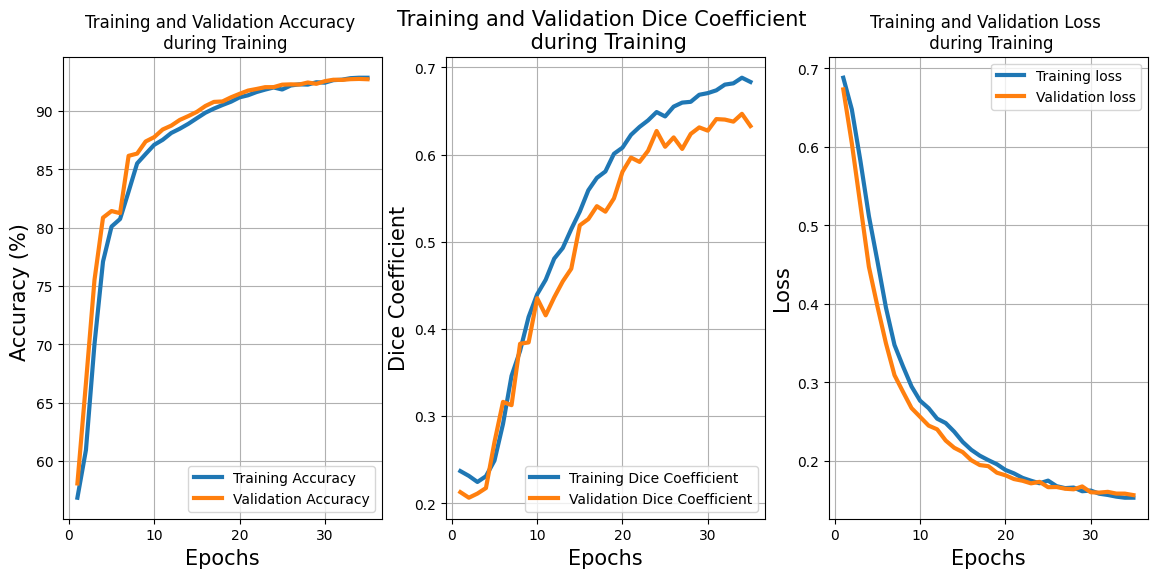

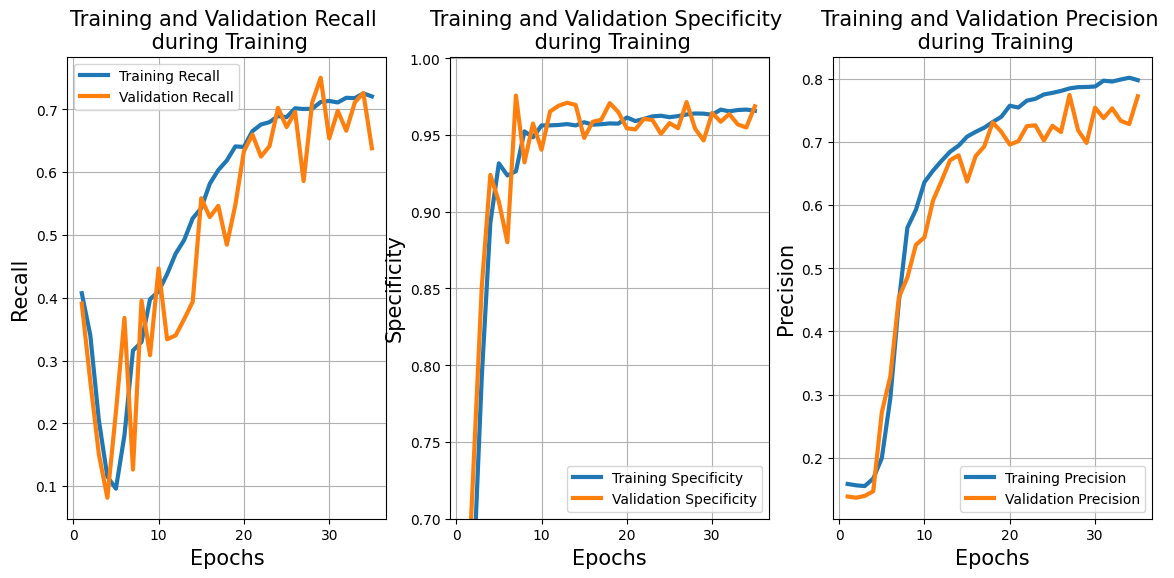

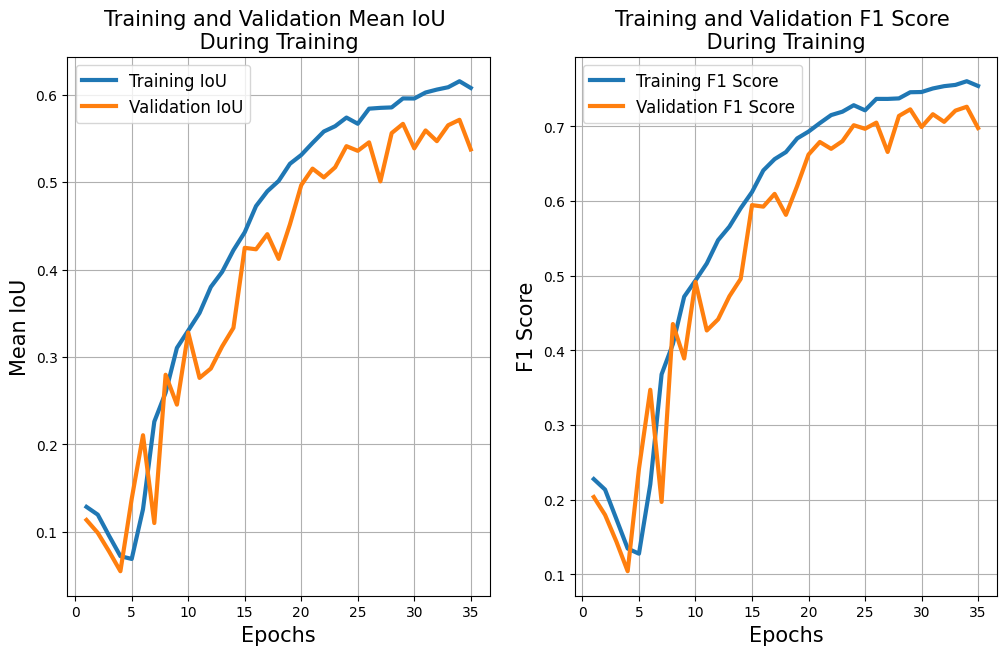

In [55]:
x_epoch= list(range(1, num_epochs_fcn_1+1))


#################################################################################
loss_train_FCN_N = History_fcn_Notall.history['loss']
loss_val_FCN_N = History_fcn_Notall.history['val_loss']

Train_acc_FCN_N=   [  item*100 for item in History_fcn_Notall.history['accuracy'] ]

Val_acc_FCN_N =[item*100 for item in History_fcn_Notall.history['val_accuracy'] ]


#train_mean_io = history_Notall.history['mean_io_u_2']
#val_mean_io = history_Notall.history['val_mean_io_u_2']

precision_train_FCN_N = History_fcn_Notall.history['multi_class_precision']
precision_val_FCN_N = History_fcn_Notall.history['val_multi_class_precision']

dice_train_FCN_N = History_fcn_Notall.history['Dice_Coef']
dice_val_FCN_N = History_fcn_Notall.history['val_Dice_Coef']

train_recall_FCN_N = History_fcn_Notall.history['multi_class_recall']
val_recall_FCN_N = History_fcn_Notall.history['val_multi_class_recall']

specificity_train_FCN_N = History_fcn_Notall.history['multi_class_specificity']
specificity_val_FCN_N = History_fcn_Notall.history['val_multi_class_specificity']

IoU_train_FCN_N =History_fcn_Notall.history['custom_mean_ioutow']
IoU_val_FCN_N =History_fcn_Notall.history['val_custom_mean_ioutow']
# #################################################################################





plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(x_epoch, Train_acc_FCN_N, lw=3, label='Training Accuracy')
plt.plot(x_epoch, Val_acc_FCN_N, lw=3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy \n during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy (%) ', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(x_epoch, dice_train_FCN_N, lw=3, label='Training Dice Coefficient')
plt.plot(x_epoch, dice_val_FCN_N, lw=3, label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Dice Coefficient', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(x_epoch, loss_train_FCN_N, lw=3, label='Training loss')
plt.plot(x_epoch, loss_val_FCN_N, lw=3, label='Validation loss')
plt.title('Training and Validation Loss \n during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(x_epoch, train_recall_FCN_N, lw=3, label='Training Recall')
plt.plot(x_epoch, val_recall_FCN_N, lw=3, label='Validation Recall')
plt.title('Training and Validation Recall \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.legend()
plt.grid()


plt.subplot(1, 3, 2)
plt.plot(x_epoch, specificity_train_FCN_N, lw=3, label='Training Specificity')
plt.plot(x_epoch, specificity_val_FCN_N, lw=3, label='Validation Specificity')
plt.title('Training and Validation Specificity \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Specificity', fontsize=15)
plt.ylim(0.7,1.001)
plt.legend()
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(x_epoch, precision_train_FCN_N, lw=3, label='Training Precision')
plt.plot(x_epoch, precision_val_FCN_N, lw=3, label='Validation Precision')
plt.title('Training and Validation Precision \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(x_epoch, IoU_train_FCN_N,lw=3, label='Training IoU')
plt.plot(x_epoch, IoU_val_FCN_N, lw=3, label='Validation IoU')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean IoU', fontsize=15)
plt.title('Training and Validation Mean IoU \n During Training ', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)

fcn_f1val = History_fcn_Notall.history['val_f1_score']
fcn_f1train = History_fcn_Notall.history['f1_score']
plt.subplot(1, 2, 2)
plt.plot(x_epoch, fcn_f1train,lw=3, label='Training F1 Score')
plt.plot(x_epoch, fcn_f1val, lw=3, label='Validation F1 Score')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('Training and Validation F1 Score \n During Training ', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

35

35

<Figure size 1200x1200 with 0 Axes>

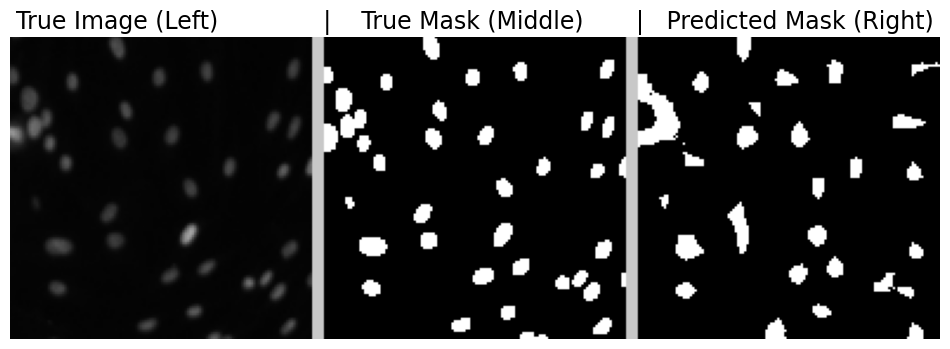

<Figure size 1200x1200 with 0 Axes>

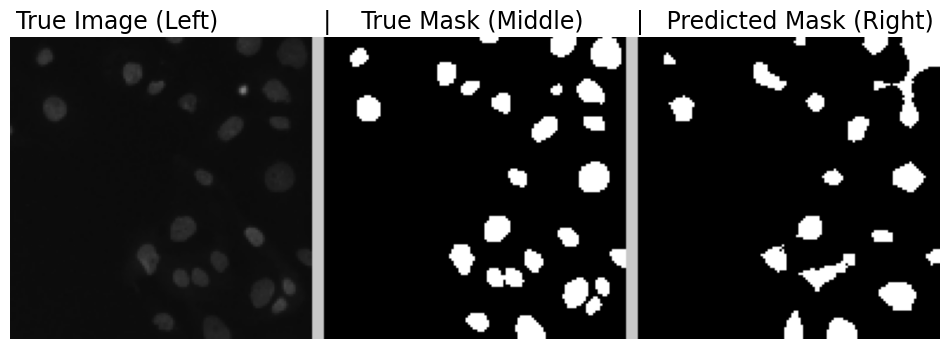

<Figure size 1200x1200 with 0 Axes>

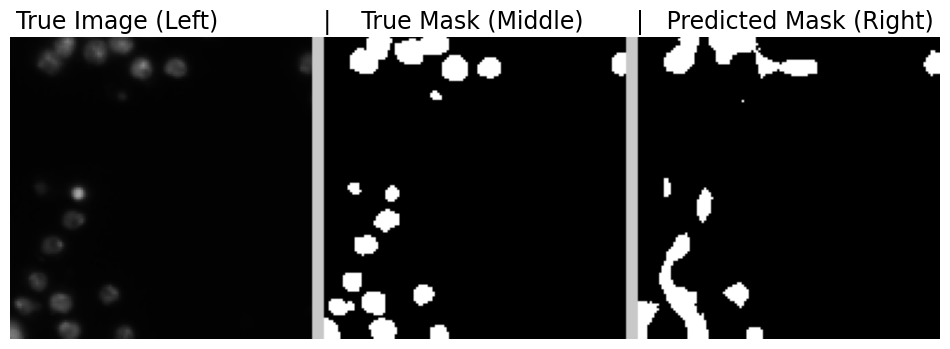

In [56]:
predict_mask_and_mergeimage(X_test, y_test, 7, 3, FCN_model_Notall)


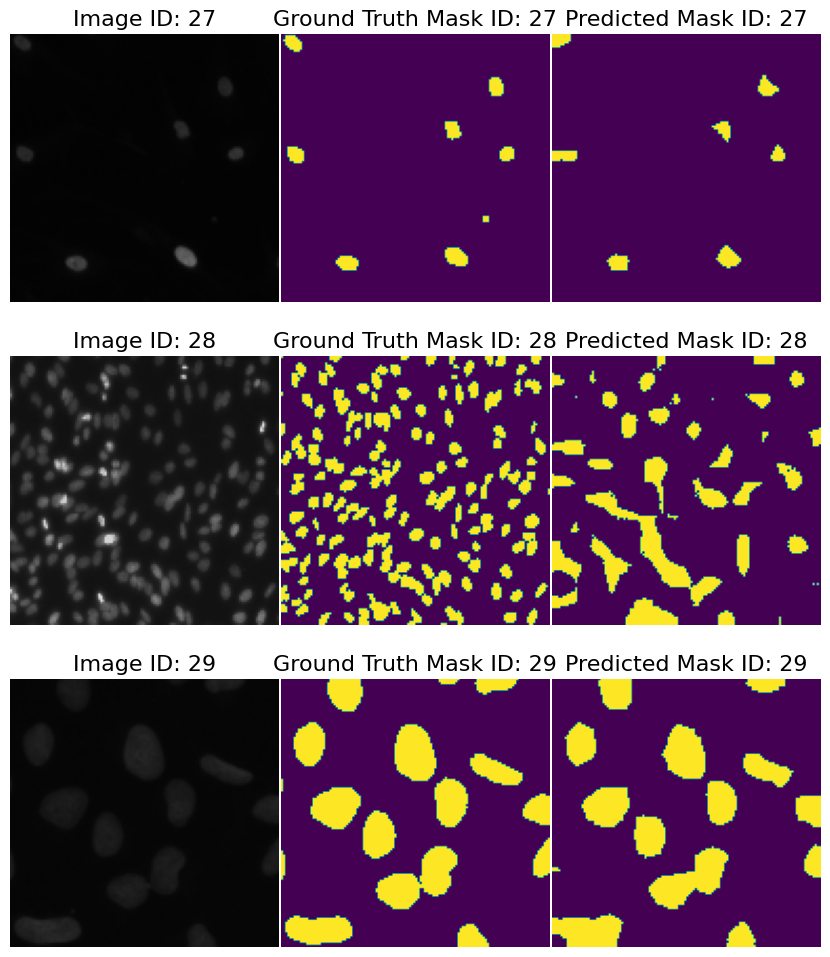

In [58]:
predict_mask_nomerge(X_test, y_test, 27, 3, FCN_model_Notall)

In [59]:
unseen_masks_fcn= y_test.copy()
# Generating predictions
y_pred_proba_fcn = FCN_model_Notall.predict(X_test)
y_pred_fcn = (y_pred_proba_fcn >= 0.5).astype(np.uint8) 

y_pred_proba_fcn = y_pred_proba_fcn.flatten()
y_true_flat_fcn = unseen_masks_fcn.flatten()

y_pred_fcn = y_pred_fcn.flatten()


3/3 [==============================] - 2s 604ms/step


              precision    recall  f1-score   support

     Pixel 0       0.95      0.97      0.96   1145041
     Pixel 1       0.78      0.65      0.71    182063

    accuracy                           0.93   1327104
   macro avg       0.86      0.81      0.83   1327104
weighted avg       0.92      0.93      0.92   1327104



IoU Mean: 0.5519
Dice Coefficient: 0.7113


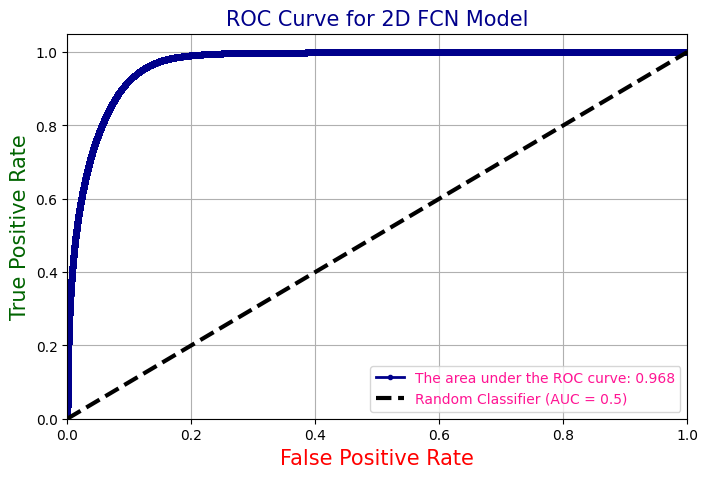

In [62]:
target_names = ['Pixel 0', 'Pixel 1']
print(classification_report(y_true_flat_fcn, y_pred_fcn, target_names=target_names))

print('\n')


# Compute Dice Coefficient
intersection_fcn = np.sum(y_true_flat_fcn * y_pred_fcn)
dice_coefficient_fcn = (2. * intersection_fcn) / (np.sum(y_true_flat_fcn) + np.sum(y_pred_fcn))

# Compute IoU (Intersection over Union)
union_fcn = np.sum(y_true_flat_fcn) + np.sum(y_pred_fcn) - intersection_fcn
iou_mean_fcn = intersection_fcn / union_fcn

print(f"IoU Mean: {iou_mean_fcn:.4f}")
print(f"Dice Coefficient: {dice_coefficient_fcn:.4f}")


fpr_fcn, tpr_fcn, _ = roc_curve(y_true_flat_fcn, y_pred_proba_fcn) 
roc_auc_fcn = np.round(auc(fpr_fcn, tpr_fcn), 3)
# Plot the ROC curve
plt.figure(figsize=(8,5))  
plt.plot(fpr_fcn, tpr_fcn, '.-', lw=2, color='darkblue',  label=f'The area under the ROC curve: {roc_auc_fcn}')
plt.plot([0, 1], [0, 1], 'k--', lw=3, color='black', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15, color='red')
plt.ylabel('True Positive Rate', fontsize=15, color='darkgreen')
plt.title('ROC Curve for 2D FCN Model', fontsize=15, color='darkblue')


legend = plt.legend()
for text in legend.get_texts():
    text.set_color('deeppink')

# ax = plt.gca()
# ax.xaxis.label.set_color('blue')
# ax.yaxis.label.set_color('blue')
plt.grid(True)
plt.show()

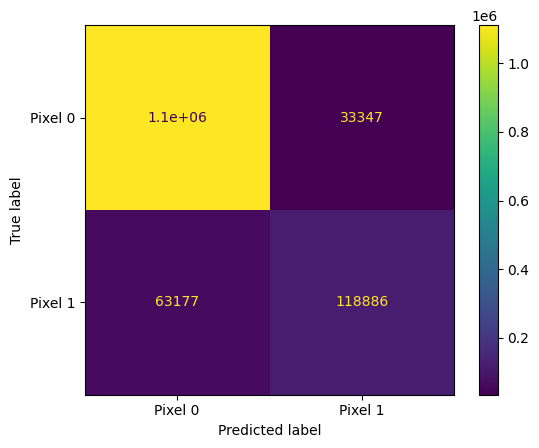

In [61]:


confusion_matrix_fcn = metrics.confusion_matrix(y_true_flat_fcn, y_pred_fcn)

cm_display_fcn = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_fcn, display_labels = ['Pixel 0', 'Pixel 1'])

cm_display_fcn.plot()
plt.show()

# Key Points

- <span style="font-size:20px; color:blue;">The 2018 Data Science Bowl competition provided a training set with images and annotated masks as labels, and a testing dataset without labels or annotated masks.</span>


- <span style="font-size:20px; color:green;">Above, we have divided the released training dataset into training, validation, and testing datasets for training, validating parameters, and evaluating the model.</span>



- <span style="font-size:20px; color:red;">This means that our testing dataset was part of the training dataset released during the training stage, but the purpose of the competition is to predict masks on the testing dataset released by the 2018 Data Science Bowl committee.</span>



- <span style="font-size:20px; color:purple;">From now on, we aim to create a new split for training the model using the entire dataset and evaluating it with the provided testing dataset where the masks are held back.</span>


- <span style="font-size:20px; color:orange;">In machine learning, we typically split the data into a training dataset, a validation dataset to monitor and optimize the metrics, and a testing dataset for evaluating the final model.</span>


- <span style="font-size:20px; color:teal;">Here, we divide the released training dataset provided by the 2018 Data Science Bowl into training and validation datasets for training and validating the model.</span>

- <span style="font-size:20px; color:maroon;">In the data generator, we have split the data into 80% for training and 20% for validation.</span>

In [63]:
# This function takes the testing dataset provided by the Data Science Bowl 2018, a trained model, a start index, 
# and a number of images to predict their masks.It is important to note that in this section, we are solely predicting 
# the masks without having the ground truth masks.The image from the holdout dataset from the Data Science Bowl 2018 will be merged
# with the predicted mask on the right, while the image will be on the left, separated by a line.


def predict_mask_only_merge(Real_images,  start_index, num_predicions, model):

    plt.figure(figsize=(24,12))
    nrows = int(np.ceil(num_predicions/2))
    for index in range(start_index, start_index +num_predicions ):
        image = Real_images[index]
    
        iter = index- start_index
 
        image_input = np.expand_dims(image, axis=0)  # Add batch dimension
        image=image*255
        y_pred = model.predict(image_input, verbose=0)[0]
        y_pred = (y_pred >= 0.5).astype(np.uint8)  # Apply threshold



        # Apply color maps to the masks
        y_pred_colored = np.zeros_like(image)

        for i in range(3):  # Apply the mask to all color channels
            y_pred_colored[..., i] = np.squeeze(y_pred) * 255

        # Create a separator line
        line = np.ones((image.shape[0], 5, 3)) * 200

        # Concatenate image, real mask, and predicted mask
       
        merged_images = np.concatenate([image, line, y_pred_colored], axis=1)

        # Plot the concatenated image
        plt.subplot(nrows, 2, iter+1)
        #plt.subplot(num_predicions, 1, index+1)
        #plt.figure(figsize=(12, 4))
        plt.title('True Image (Left)         | Predicted Mask (Right)', fontsize=19)
        plt.imshow(merged_images.astype(np.uint8), cmap="YlGnBu")
        plt.xlabel('Merged Images')
        plt.axis('off')
        #plt.show()

    plt.tight_layout()

In [77]:
# This function takes a set of images, a start index, a number of images to predict their masks, and a trained model.
# Unlike the previous function, this one predicts masks and displays them directly alongside the original images without merging them with a separator line.
# Each row in the plot will show the original image on the left and the predicted mask on the right.


def predict_mask_side_by_side(images, index_start, number_images, model):

    plt.figure(figsize=(27,14))

    for iter in range(index_start, index_start+number_images):
        image = images[iter]
       
        input_image = np.expand_dims(image, axis=0)
        pred_image = model.predict(input_image, verbose=0)[0]

        pred_image = (pred_image>=0.5).astype(np.int8)

        pred_image = np.squeeze(pred_image, axis=-1)

        index= (iter - index_start) * 2


        plt.subplot(number_images, 2, index+1)
        plt.imshow(image, cmap='viridis')
        plt.title(f'Image: {iter}', fontsize=16)
        plt.axis('off')


        plt.subplot(number_images, 2, index+2)
        plt.imshow(pred_image, cmap='viridis')
        plt.title(f'Predicted Mask: {iter}', fontsize=16)
        plt.axis('off')

        plt.subplots_adjust(left=0.2, right=0.5, top=1.4, bottom=0.33, wspace=0.001, hspace=0.1)
    plt.show()




- <span style="font-size:29px; color:blue;">Training and validating the U-Net 2D model with the entire dataset provided in the training phase.</span>

- <span style="font-size:29px; color:pink;"> 80% of the data is split for training and 20% for validating the model.</span>

- <span style="font-size:29px; color:olive;">Then the model will be used to predict the masks on the testing dataset provided by the 2018 Data Science Bowl competition.</span>

In [65]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(All_imagage_train, All_masks_train, test_size=0.18, random_state=42)

In [66]:
Y_train_all = (Y_train_all>0).astype(np.int8)
Y_val_all = (Y_val_all>0).astype(np.int8)

In [68]:
Unet2D_all = My_Unet_2D(input_size=input_layer, num_filter=40, Pool_size =2 ,  pool_stride=2, drop_rate=0.20, num_classes=2)
optimaz_all= tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)


Unet2D_all.compile(loss="binary_crossentropy",
              optimizer=optimaz_all,
              metrics = ['accuracy',custom_mean_ioutow,
                          Dice_Coef, multi_class_precision, multi_class_recall, multi_class_specificity, f1_score] )
# Create directory for storing files
if not os.path.exists("Files_all"):
    os.makedirs("Files_all")

# Hyperparameters and file paths
model_path = os.path.join("Files_all", "MyModel_ll.h5")
csv_path = os.path.join("Files_all", "Traing_all.log")

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001, verbose=1),
    
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True, save_weights_only=True),

    CSVLogger(csv_path, separator=',', append=False),
    
    EarlyStopping(monitor='val_loss', patience=14, restore_best_weights=False)
]




history_all_Unet =Unet2D_all.fit(X_train_all, Y_train_all,
          epochs=epoch_numer_all_unet,
          callbacks=callbacks,
          validation_data=(X_val_all, Y_val_all))

Block_6_upsample -- (None, 16, 16, 320)
Block4_Conv8 -- (None, 16, 16, 320)
Sigmoid used
Epoch 1/45
18/18 [==============================] - ETA: 0s - loss: 0.6145 - accuracy: 0.8121 - custom_mean_ioutow: 0.0108 - Dice_Coef: 0.1944 - multi_class_precision: 0.0723 - multi_class_recall: 0.0458 - multi_class_specificity: 0.9559 - f1_score: 0.0193
Epoch 1: val_loss improved from inf to 0.49170, saving model to Files_all/MyModel_ll.h5
18/18 [==============================] - 61s 3s/step - loss: 0.6145 - accuracy: 0.8121 - custom_mean_ioutow: 0.0108 - Dice_Coef: 0.1944 - multi_class_precision: 0.0723 - multi_class_recall: 0.0458 - multi_class_specificity: 0.9559 - f1_score: 0.0193 - val_loss: 0.4917 - val_accuracy: 0.8621 - val_custom_mean_ioutow: 1.5050e-15 - val_Dice_Coef: 0.1876 - val_multi_class_precision: 0.0000e+00 - val_multi_class_recall: 0.0000e+00 - val_multi_class_specificity: 1.0000 - val_f1_score: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/45
18/18 [==============================] - ET

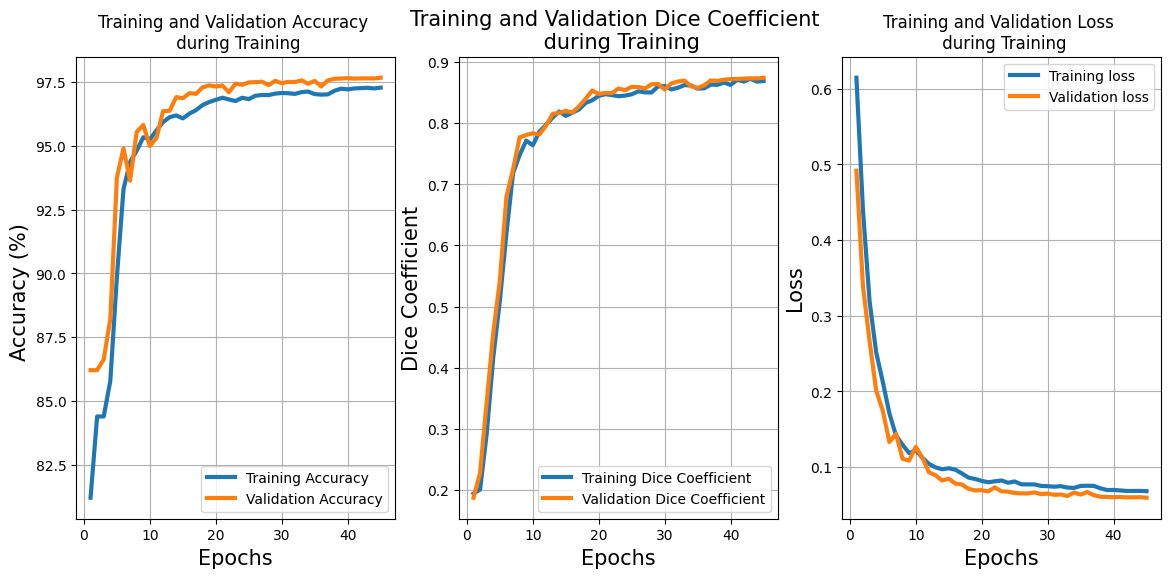

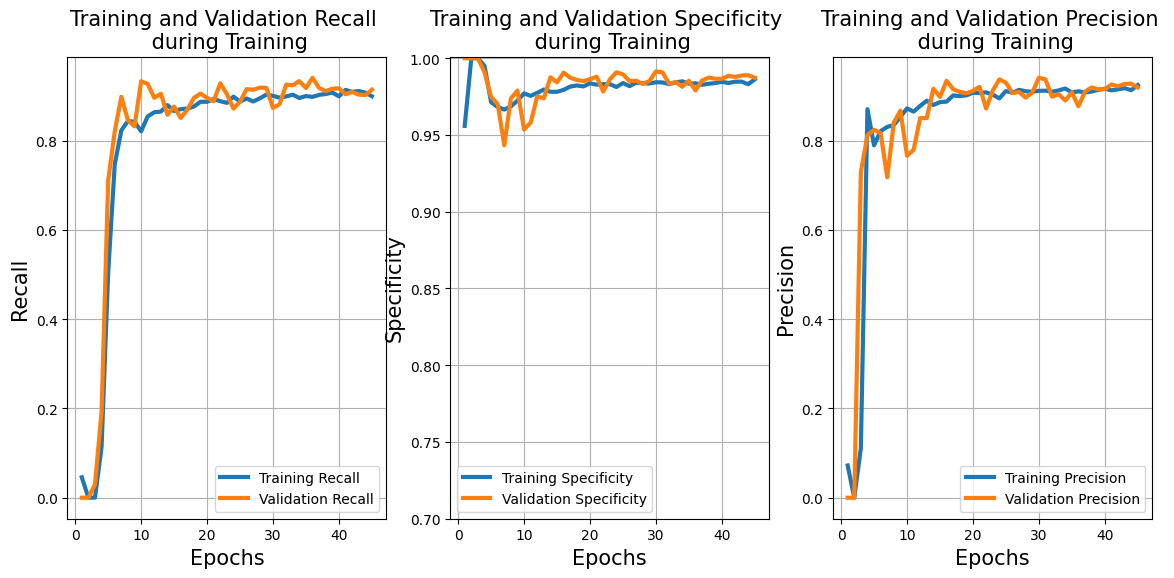

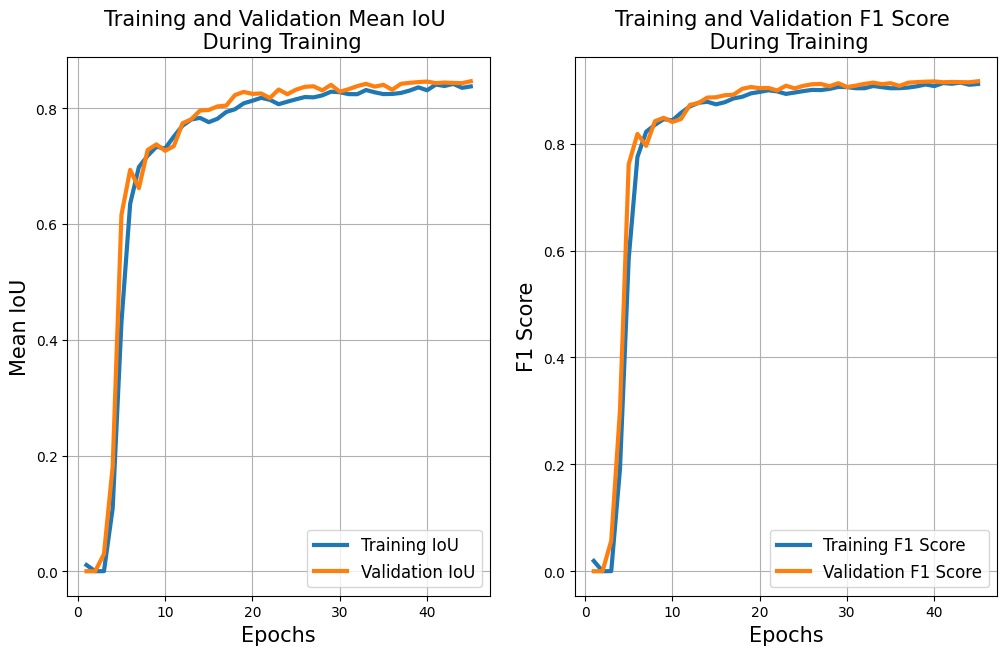

In [71]:
X= list(range(1, epoch_numer_all_unet+1))

#################################################################################
loss_train_allU = history_all_Unet.history['loss']
loss_val_allU = history_all_Unet.history['val_loss']

Train_acc_allU =   [  item*100 for item in history_all_Unet.history['accuracy'] ]

Val_acc_allU =[item*100 for item in history_all_Unet.history['val_accuracy'] ]


#train_mean_io = history_Notall.history['mean_io_u_2']
#val_mean_io = history_Notall.history['val_mean_io_u_2']

precision_train_allU = history_all_Unet.history['multi_class_precision']
precision_val_allU = history_all_Unet.history['val_multi_class_precision']

dice_train_allU = history_all_Unet.history['Dice_Coef']
dice_val_allU = history_all_Unet.history['val_Dice_Coef']

train_recall_allU = history_all_Unet.history['multi_class_recall']
val_recall_allU = history_all_Unet.history['val_multi_class_recall']

specificity_train_allU = history_all_Unet.history['multi_class_specificity']
specificity_val_allU = history_all_Unet.history['val_multi_class_specificity']
IoU_train_allU =history_all_Unet.history['custom_mean_ioutow']
IoU_val_allU=history_all_Unet.history['val_custom_mean_ioutow']

Uf1score_train = history_all_Unet.history['f1_score']
Uf1score_val = history_all_Unet.history['val_f1_score']
#################################################################################





plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(X, Train_acc_allU, lw=3, label='Training Accuracy')
plt.plot(X, Val_acc_allU, lw=3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy \n during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy (%) ', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(X, dice_train_allU, lw=3, label='Training Dice Coefficient')
plt.plot(X, dice_val_allU, lw=3, label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Dice Coefficient', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(X, loss_train_allU, lw=3, label='Training loss')
plt.plot(X, loss_val_allU, lw=3, label='Validation loss')
plt.title('Training and Validation Loss \n during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(X, train_recall_allU, lw=3, label='Training Recall')
plt.plot(X, val_recall_allU, lw=3, label='Validation Recall')
plt.title('Training and Validation Recall \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.legend()
plt.grid()


plt.subplot(1, 3, 2)
plt.plot(X, specificity_train_allU, lw=3, label='Training Specificity')
plt.plot(X, specificity_val_allU, lw=3, label='Validation Specificity')
plt.title('Training and Validation Specificity \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Specificity', fontsize=15)
plt.ylim(0.7,1.001)
plt.legend()
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(X, precision_train_allU, lw=3, label='Training Precision')
plt.plot(X, precision_val_allU, lw=3, label='Validation Precision')
plt.title('Training and Validation Precision \n during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
plt.plot(X, IoU_train_allU,lw=3, label='Training IoU')
plt.plot(X, IoU_val_allU, lw=3, label='Validation IoU')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean IoU', fontsize=15)
plt.title('Training and Validation Mean IoU \n During Training', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(X, Uf1score_train,lw=3, label='Training F1 Score')
plt.plot(X, Uf1score_val, lw=3, label='Validation F1 Score')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('Training and Validation F1 Score \n During Training', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()



In [94]:
for metricc  in history_all_Unet.history:
    print(f'Metric {metricc} has the maximum value: {max(history_all_Unet.history[metricc])}')
    print('')

Metric loss has the maximum value: 0.6145353317260742

Metric accuracy has the maximum value: 0.9727751016616821

Metric custom_mean_ioutow has the maximum value: 0.8424577713012695

Metric Dice_Coef has the maximum value: 0.8723094463348389

Metric multi_class_precision has the maximum value: 0.9249436855316162

Metric multi_class_recall has the maximum value: 0.914130449295044

Metric multi_class_specificity has the maximum value: 1.0

Metric f1_score has the maximum value: 0.9142795205116272

Metric val_loss has the maximum value: 0.4916982352733612

Metric val_accuracy has the maximum value: 0.9766689538955688

Metric val_custom_mean_ioutow has the maximum value: 0.8470572233200073

Metric val_Dice_Coef has the maximum value: 0.8740713596343994

Metric val_multi_class_precision has the maximum value: 0.9413151144981384

Metric val_multi_class_recall has the maximum value: 0.9414243698120117

Metric val_multi_class_specificity has the maximum value: 1.0

Metric val_f1_score has the 

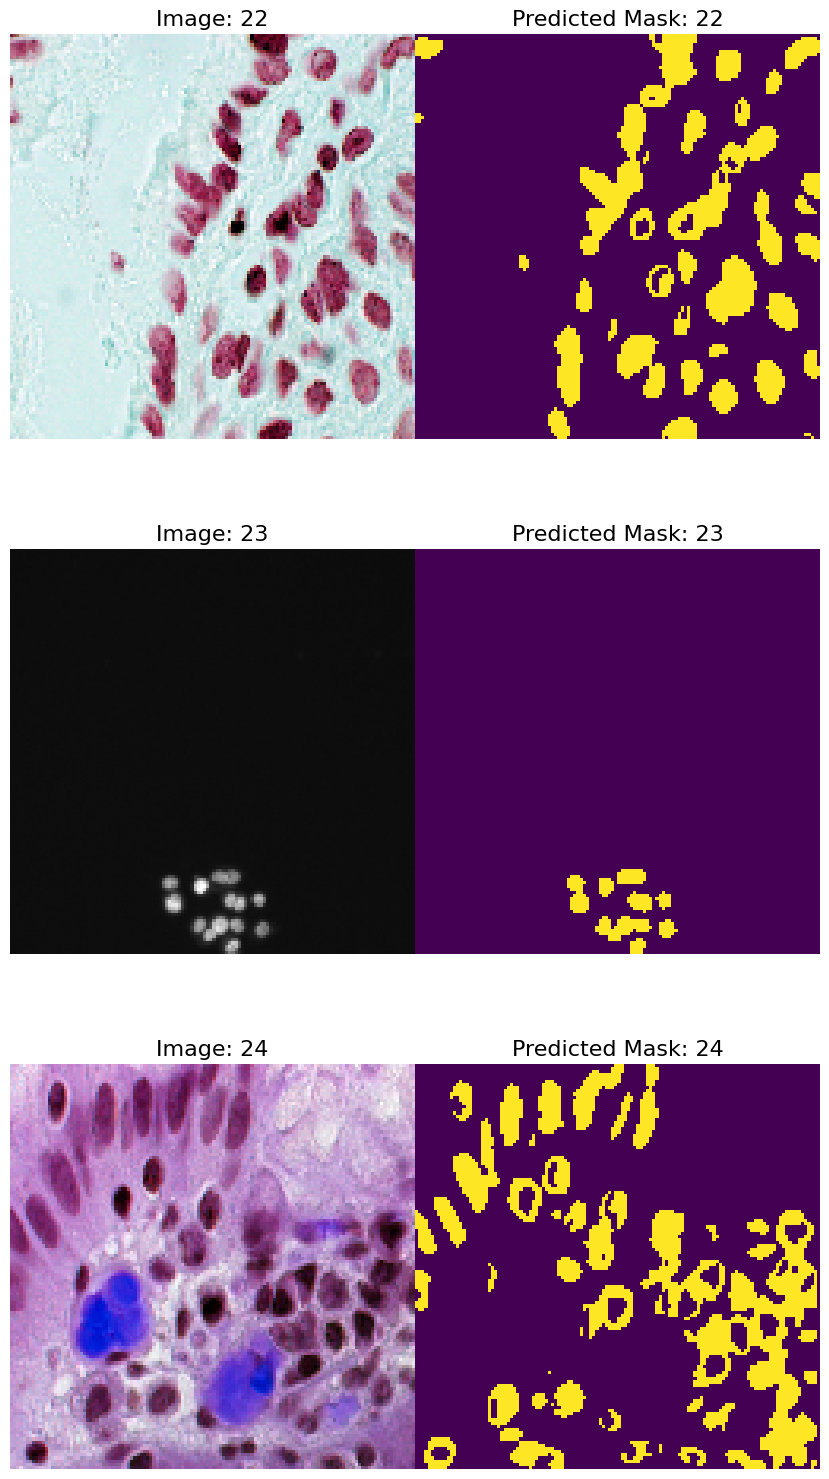

In [78]:
predict_mask_side_by_side(Unseen_data_images, 22, 3, Unet2D_all)


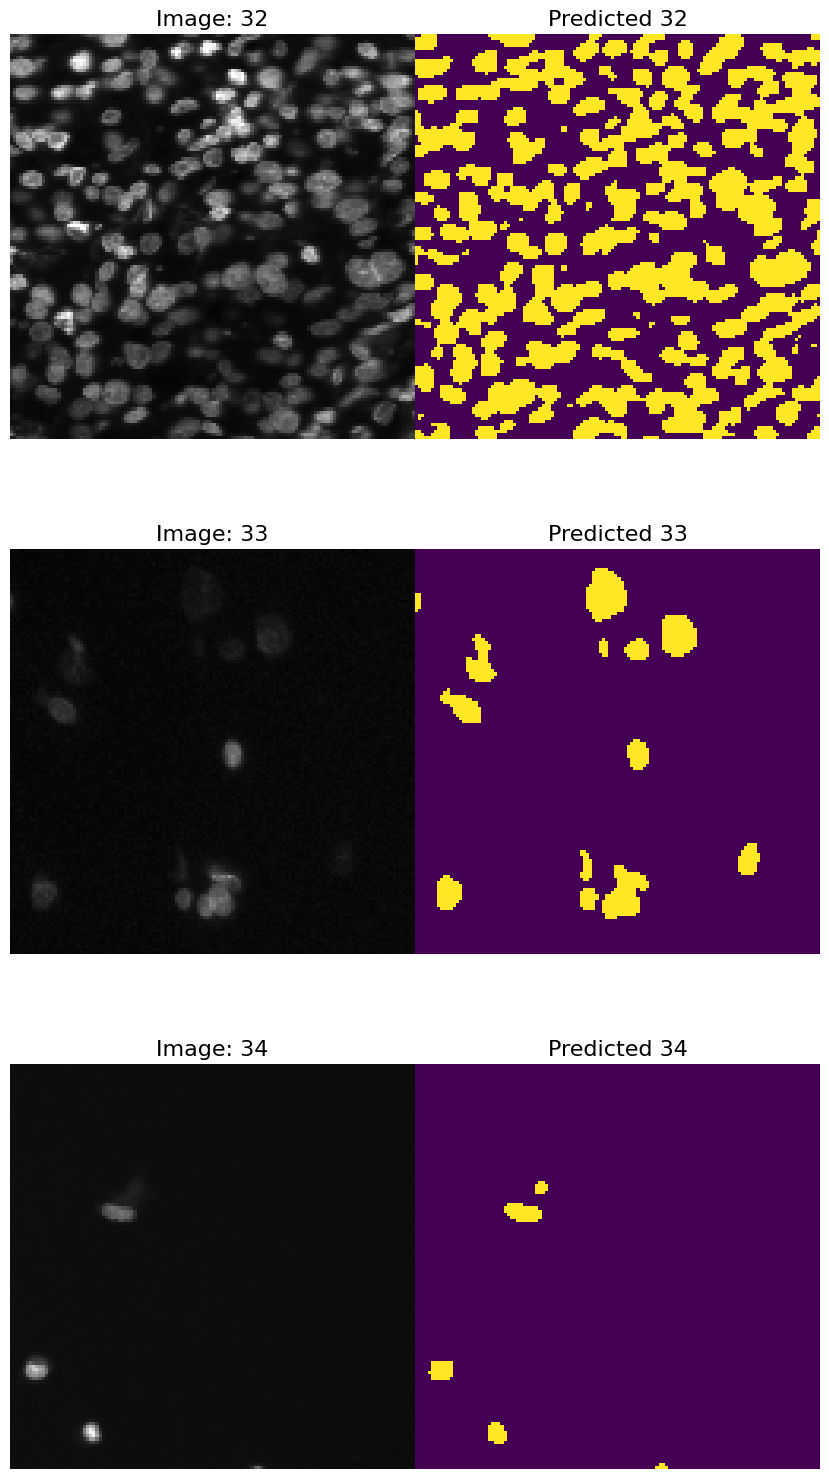

In [74]:
predict_mask_side_by_side(Unseen_data_images, 32, 3, Unet2D_all)


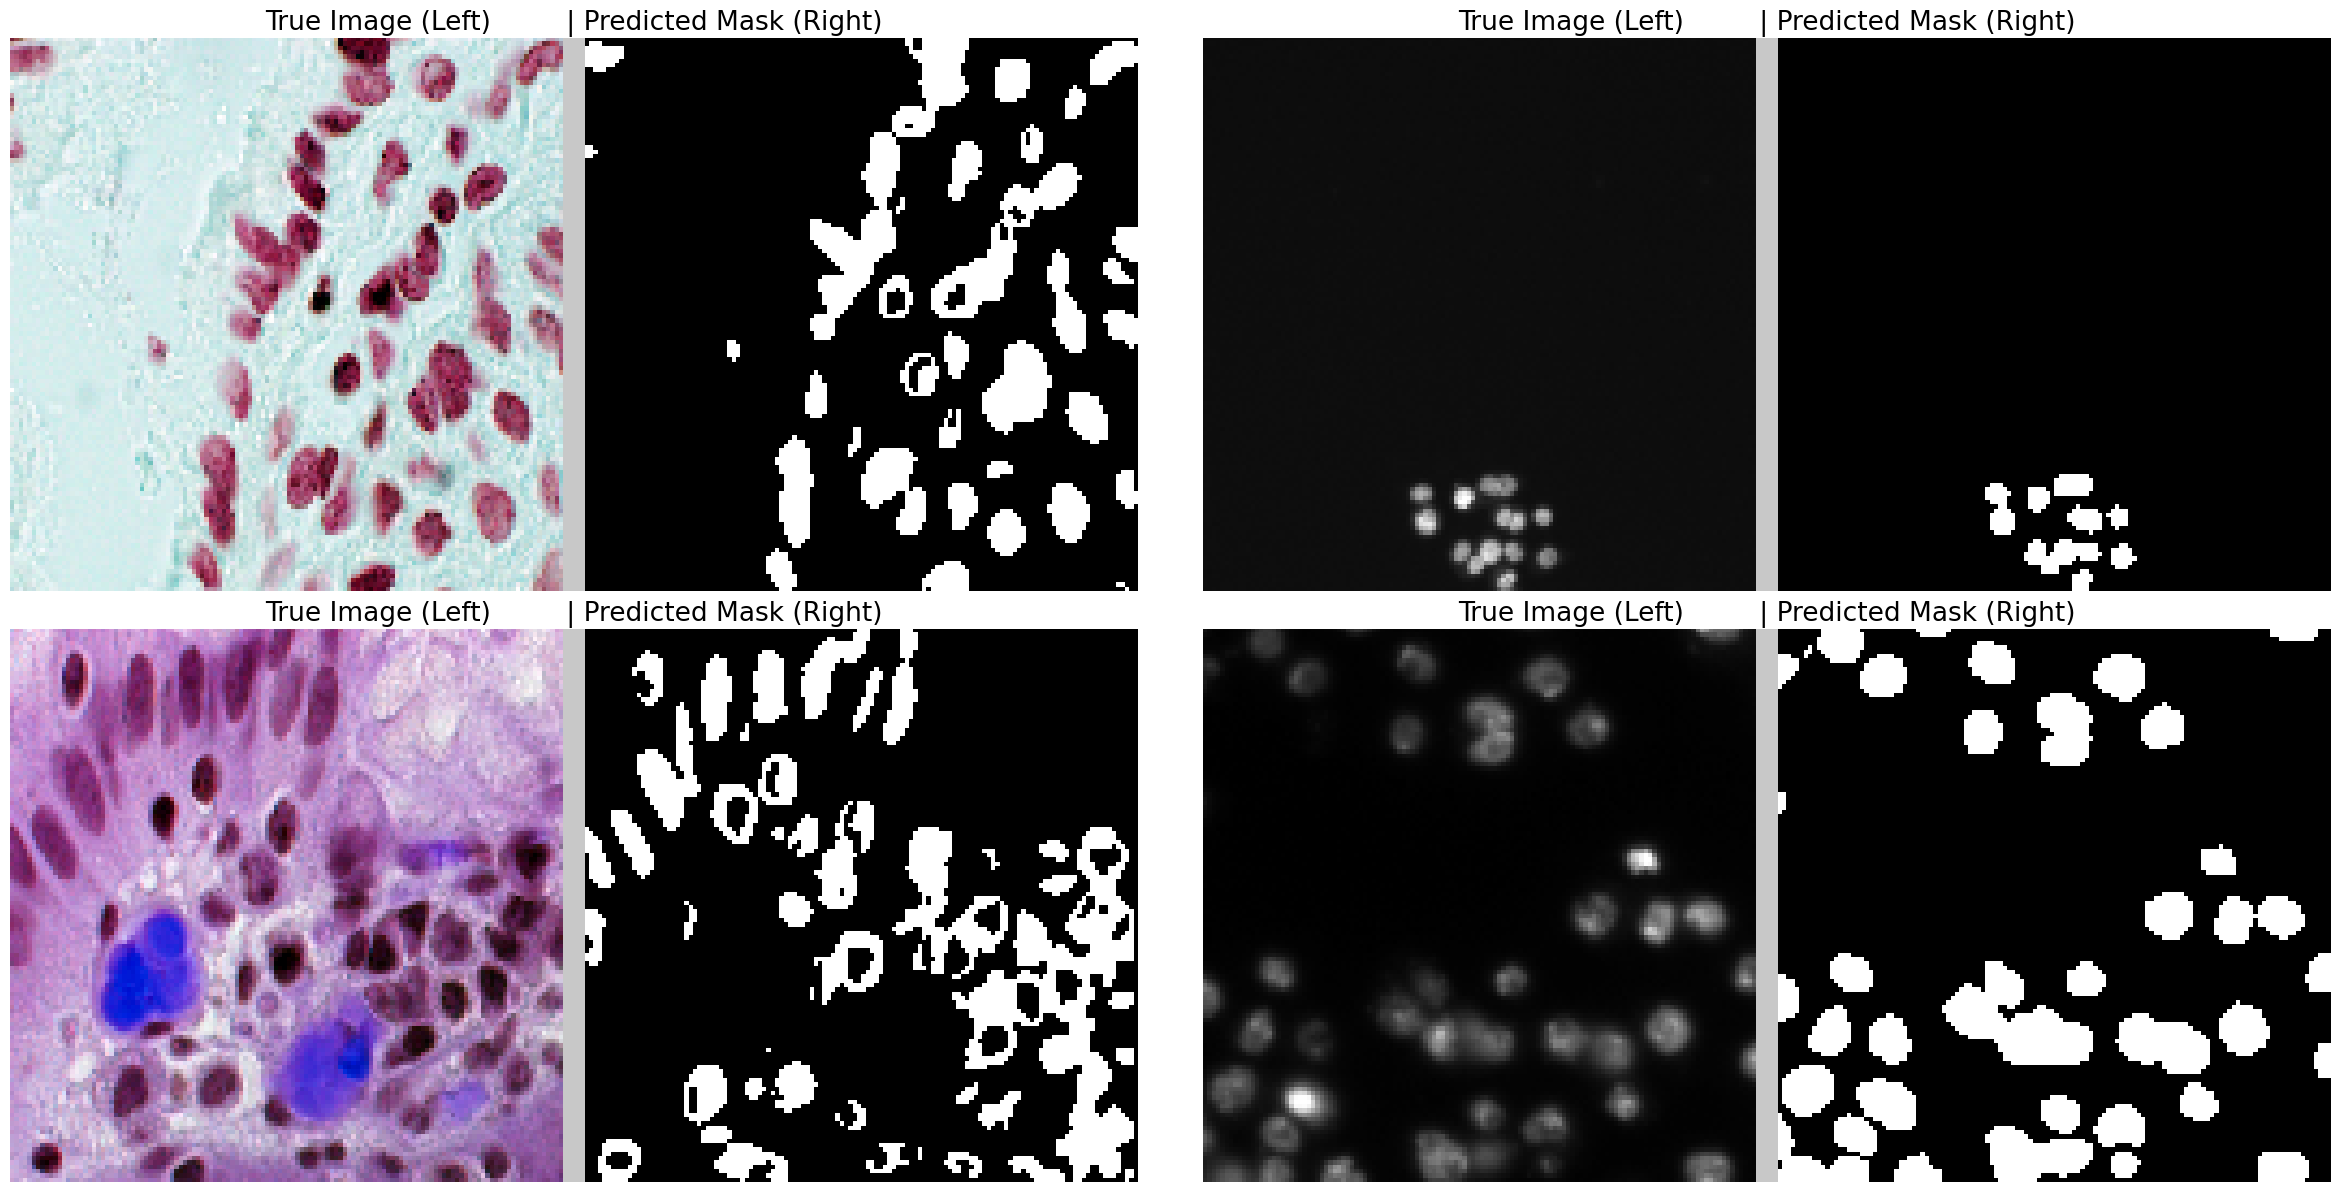

In [73]:
predict_mask_only_merge(Unseen_data_images,  22, 4, Unet2D_all)

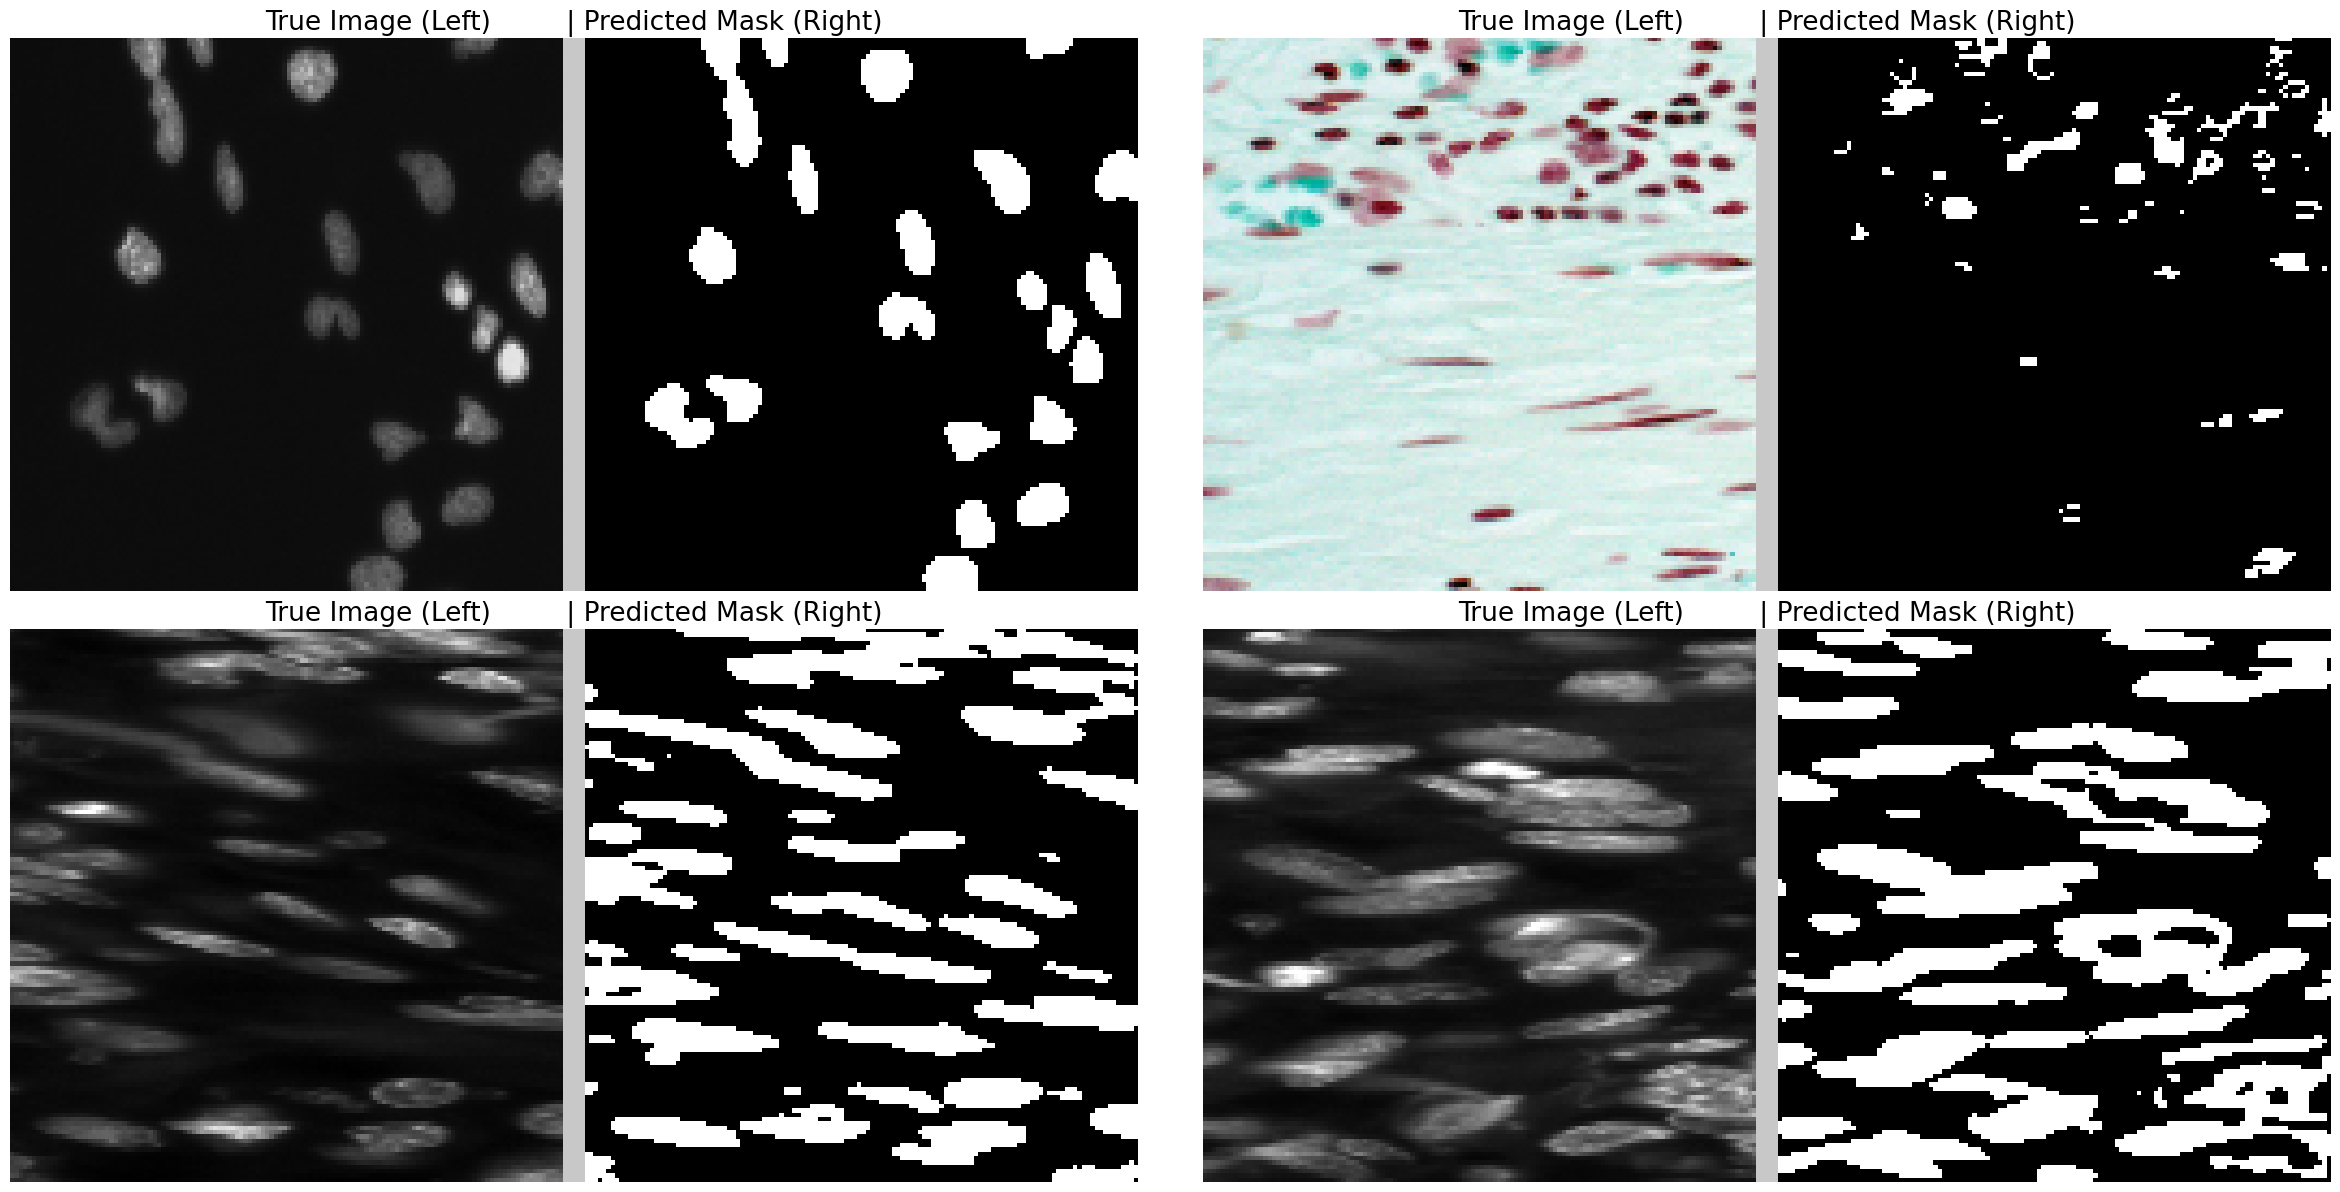

In [85]:
predict_mask_only_merge(Unseen_data_images,  50, 4, Unet2D_all)

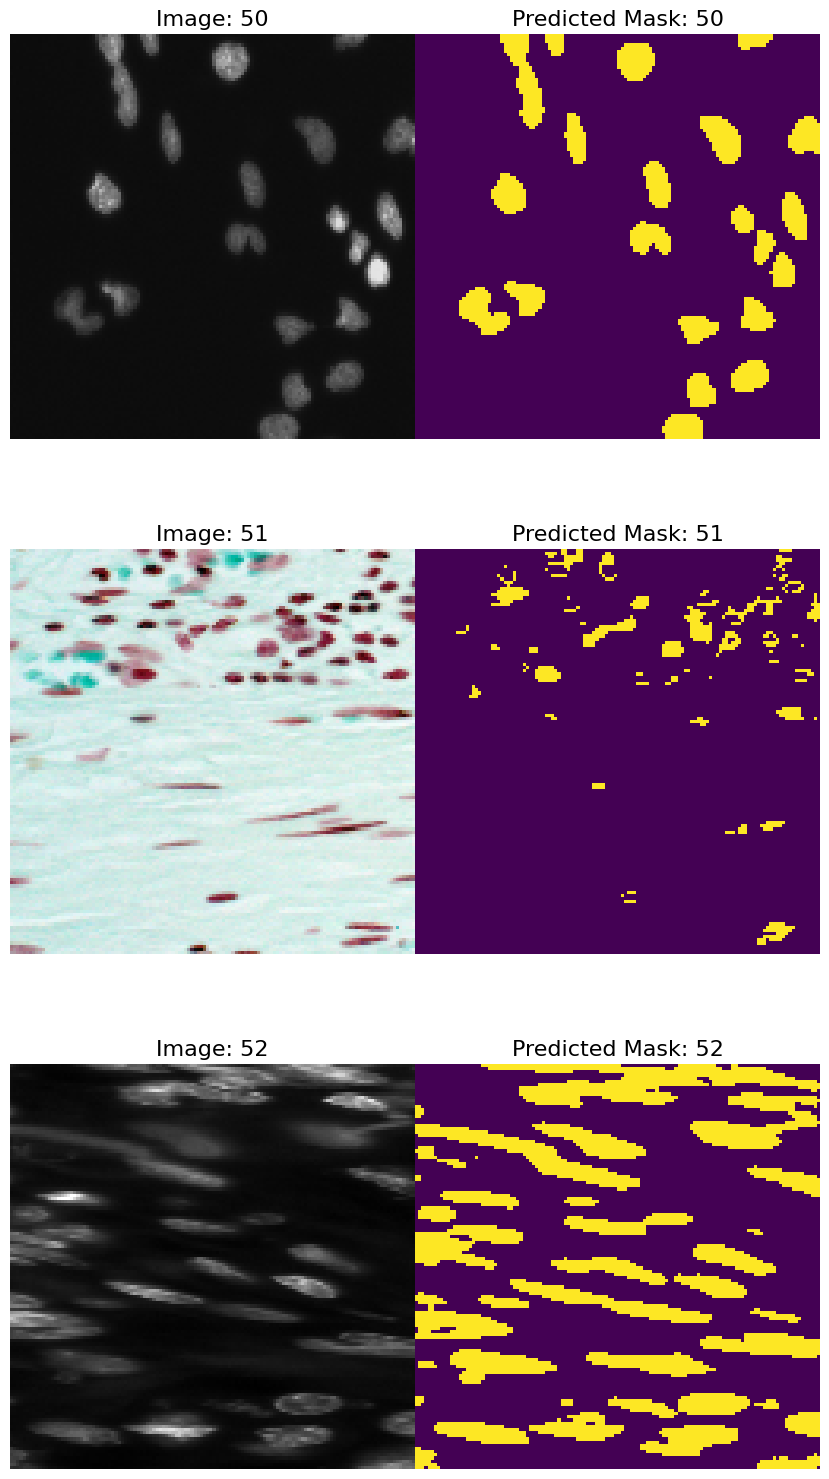

In [86]:
predict_mask_side_by_side(Unseen_data_images, 50, 3, Unet2D_all)


- <span style="font-size:29px; color:blue;">Training and validating the Fully Convolutional Networks customized VGG-like architecture with doubling filters with the entire dataset provided in the training phase.</span>

In [80]:
my_call_backs_fcn = EarlyStopping(monitor='val_loss', patience=10)
FCN_model_All = FullyConvolutional_NeuralNetWork(input_shape=(128, 128, 3), filter_choice=35, drop_rate=0.3, num_classes=1)

# Compile the model
FCN_model_All.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',custom_mean_ioutow,
                          Dice_Coef, multi_class_precision, multi_class_recall, multi_class_specificity, f1_score])

# Model summary
#model_test.summary()


History_fcn_All =FCN_model_All.fit(X_train_all, Y_train_all, epochs=num_epochs_fcn_all,
                       callbacks=my_call_backs_fcn, validation_data=(X_val_all, Y_val_all), batch_size=32)

Epoch 1/37
18/18 [==============================] - 77s 4s/step - loss: 0.6815 - accuracy: 0.5974 - custom_mean_ioutow: 0.1214 - Dice_Coef: 0.2323 - multi_class_precision: 0.1559 - multi_class_recall: 0.3606 - multi_class_specificity: 0.6442 - f1_score: 0.2162 - val_loss: 0.6308 - val_accuracy: 0.6703 - val_custom_mean_ioutow: 0.0996 - val_Dice_Coef: 0.2080 - val_multi_class_precision: 0.1378 - val_multi_class_recall: 0.2657 - val_multi_class_specificity: 0.7351 - val_f1_score: 0.1811
Epoch 2/37
18/18 [==============================] - 69s 4s/step - loss: 0.5824 - accuracy: 0.7079 - custom_mean_ioutow: 0.0924 - Dice_Coef: 0.2223 - multi_class_precision: 0.1549 - multi_class_recall: 0.1924 - multi_class_specificity: 0.8057 - f1_score: 0.1691 - val_loss: 0.4989 - val_accuracy: 0.7642 - val_custom_mean_ioutow: 0.0726 - val_Dice_Coef: 0.1991 - val_multi_class_precision: 0.1369 - val_multi_class_recall: 0.1345 - val_multi_class_specificity: 0.8650 - val_f1_score: 0.1354
Epoch 3/37
18/18 [==

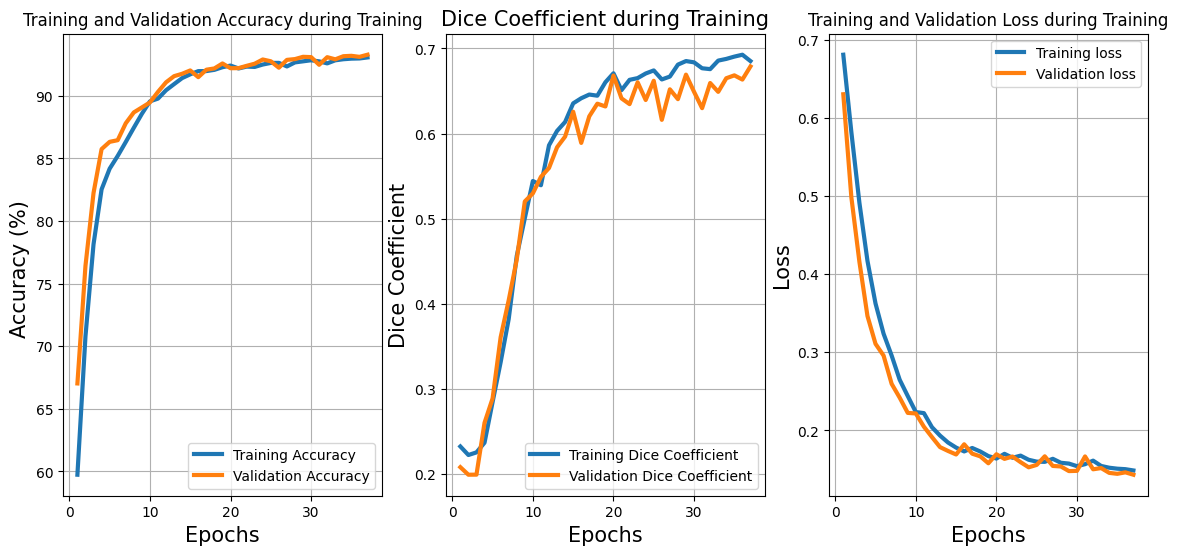

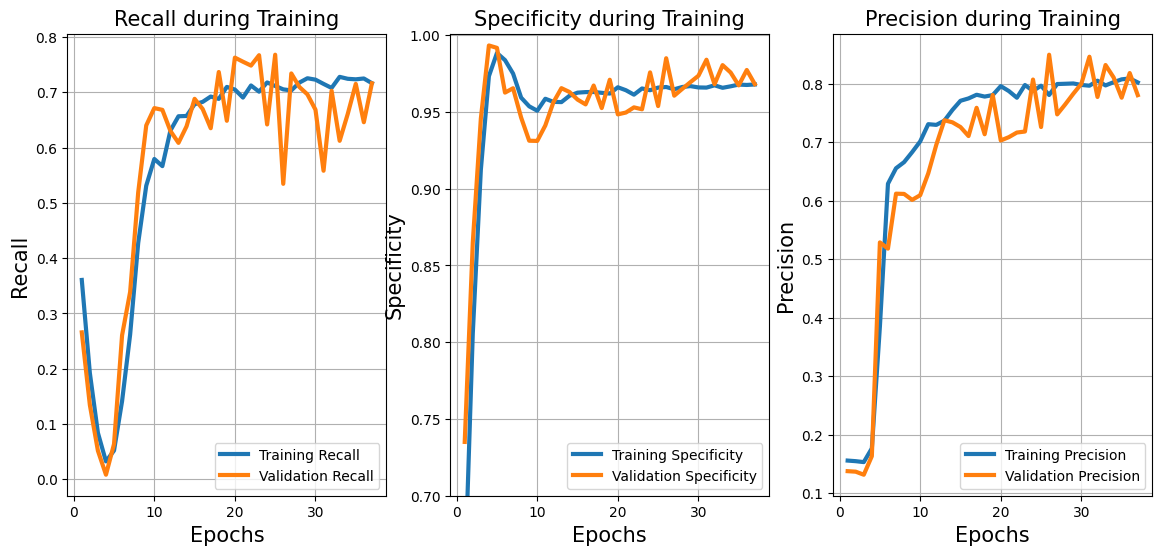

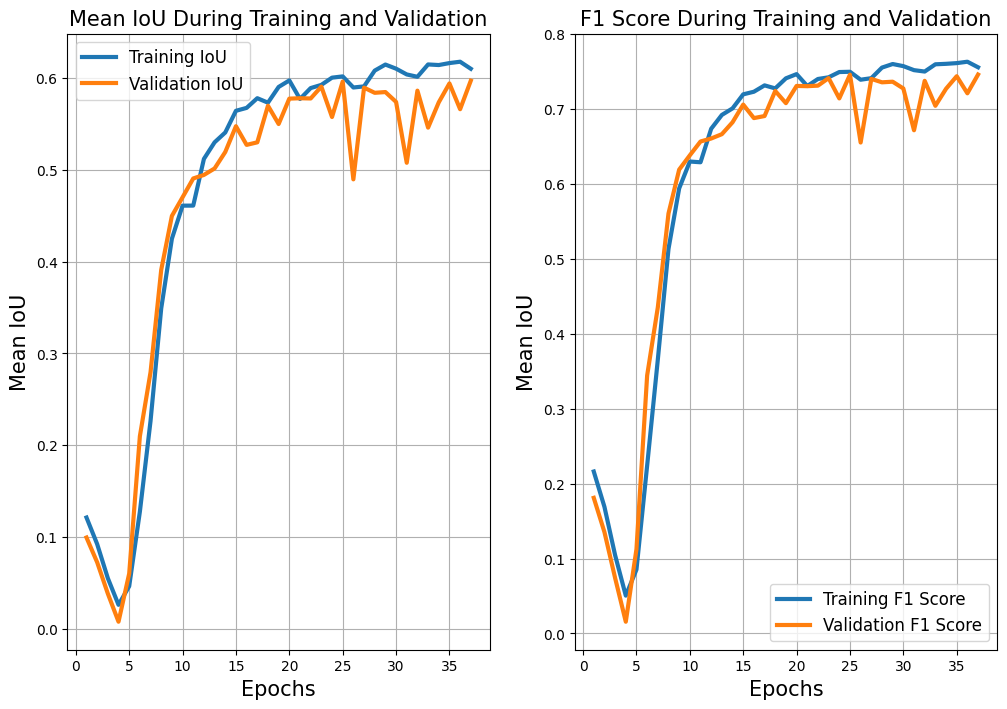

In [83]:
XX= list(range(1, num_epochs_fcn_all+1))

#################################################################################
loss_train_allFCN = History_fcn_All.history['loss']
loss_val_allFCN = History_fcn_All.history['val_loss']

Train_acc_allFCN =   [  item*100 for item in History_fcn_All.history['accuracy'] ]

Val_acc_allFCN =[item*100 for item in History_fcn_All.history['val_accuracy'] ]


#train_mean_io = history_Notall.history['mean_io_u_2']
#val_mean_io = history_Notall.history['val_mean_io_u_2']

precision_train_allFCN = History_fcn_All.history['multi_class_precision']
precision_val_allFCN = History_fcn_All.history['val_multi_class_precision']

dice_train_allFCN = History_fcn_All.history['Dice_Coef']
dice_val_allFCN = History_fcn_All.history['val_Dice_Coef']

train_recall_allFCN = History_fcn_All.history['multi_class_recall']
val_recall_allFCN = History_fcn_All.history['val_multi_class_recall']

specificity_train_allFCN = History_fcn_All.history['multi_class_specificity']
specificity_val_allFCN = History_fcn_All.history['val_multi_class_specificity']
IoU_train_allFCN  = History_fcn_All.history['custom_mean_ioutow']
IoU_val_allFCN = History_fcn_All.history['val_custom_mean_ioutow']

last_f1score_val = History_fcn_All.history['val_f1_score']
last_f1score_train = History_fcn_All.history['f1_score']
#################################################################################





plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(XX, Train_acc_allFCN, lw=3, label='Training Accuracy')
plt.plot(XX, Val_acc_allFCN, lw=3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy (%) ', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(XX, dice_train_allFCN, lw=3, label='Training Dice Coefficient')
plt.plot(XX, dice_val_allFCN, lw=3, label='Validation Dice Coefficient')
plt.title('Dice Coefficient during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Dice Coefficient', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(XX, loss_train_allFCN, lw=3, label='Training loss')
plt.plot(XX, loss_val_allFCN, lw=3, label='Validation loss')
plt.title('Training and Validation Loss during Training', fontsize=12)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(XX, train_recall_allFCN, lw=3, label='Training Recall')
plt.plot(XX, val_recall_allFCN, lw=3, label='Validation Recall')
plt.title('Recall during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.legend()
plt.grid()


plt.subplot(1, 3, 2)
plt.plot(XX, specificity_train_allFCN, lw=3, label='Training Specificity')
plt.plot(XX, specificity_val_allFCN, lw=3, label='Validation Specificity')
plt.title('Specificity during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Specificity', fontsize=15)
plt.ylim(0.7,1.001)
plt.legend()
plt.grid()


plt.subplot(1, 3, 3)
plt.plot(XX, precision_train_allFCN, lw=3, label='Training Precision')
plt.plot(XX, precision_val_allFCN, lw=3, label='Validation Precision')
plt.title('Precision during Training', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.plot(XX, IoU_train_allFCN,lw=3, label='Training IoU')
plt.plot(XX, IoU_val_allFCN, lw=3, label='Validation IoU')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean IoU', fontsize=15)
plt.title('Mean IoU During Training and Validation', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(XX, last_f1score_train,lw=3, label='Training F1 Score')
plt.plot(XX, last_f1score_val, lw=3, label='Validation F1 Score')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean IoU', fontsize=15)
plt.title('F1 Score During Training and Validation', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [93]:
for metric in History_fcn_All.history:
    print(f'Metric {metric} has the maximum value: {max(History_fcn_All.history[metric])}')
    print('')

Metric loss has the maximum value: 0.6814523339271545

Metric accuracy has the maximum value: 0.9306254982948303

Metric custom_mean_ioutow has the maximum value: 0.6176789999008179

Metric Dice_Coef has the maximum value: 0.6926801204681396

Metric multi_class_precision has the maximum value: 0.808645486831665

Metric multi_class_recall has the maximum value: 0.7279566526412964

Metric multi_class_specificity has the maximum value: 0.9884426593780518

Metric f1_score has the maximum value: 0.7632749080657959

Metric val_loss has the maximum value: 0.6307838559150696

Metric val_accuracy has the maximum value: 0.9328063726425171

Metric val_custom_mean_ioutow has the maximum value: 0.5970250964164734

Metric val_Dice_Coef has the maximum value: 0.6789104342460632

Metric val_multi_class_precision has the maximum value: 0.849176824092865

Metric val_multi_class_recall has the maximum value: 0.7679977416992188

Metric val_multi_class_specificity has the maximum value: 0.9933425784111023


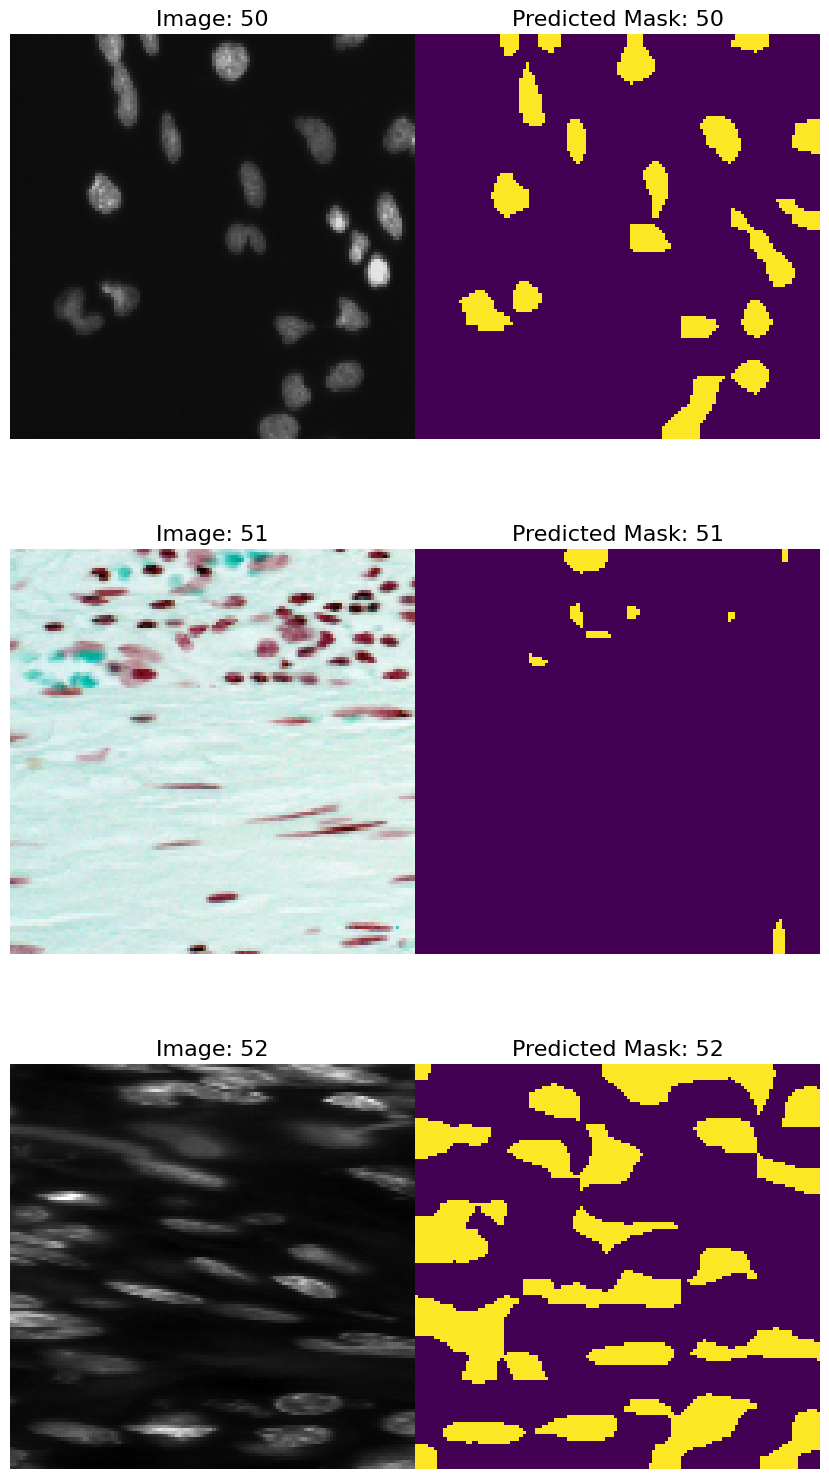

In [84]:
predict_mask_side_by_side(Unseen_data_images, 50, 3, FCN_model_All)


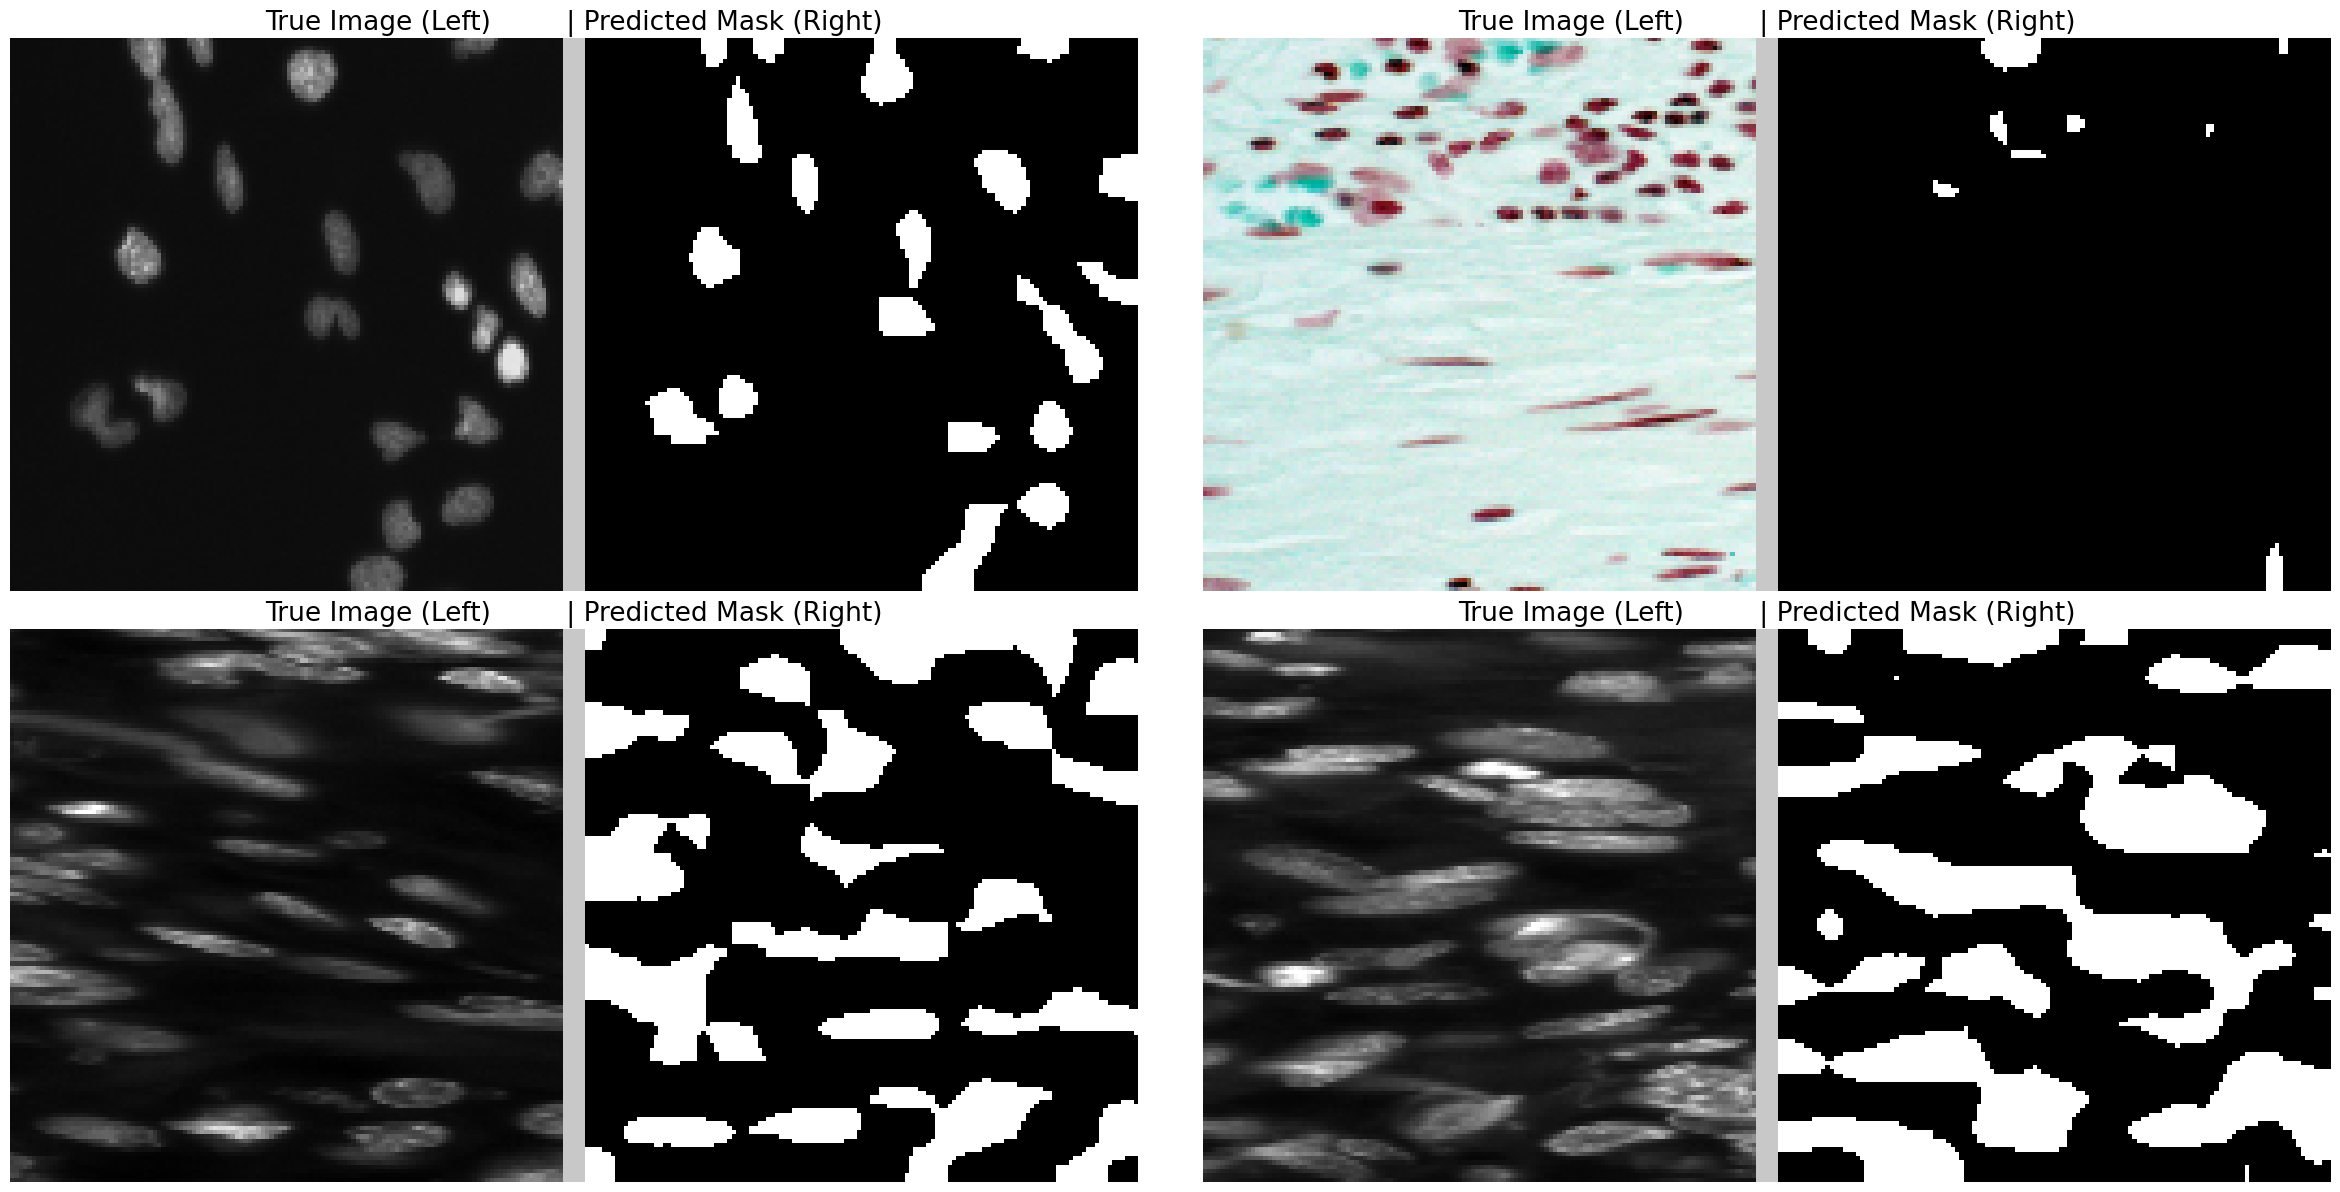

In [87]:
predict_mask_only_merge(Unseen_data_images,  50, 4, FCN_model_All)